##### Copyright 2021 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate music with an RNN


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/music_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


This tutorial shows you how to generate musical notes using a simple recurrent neural network (RNN). You will train a model using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate longer sequences of notes by calling the model repeatedly.

This tutorial contains complete code to parse and create MIDI files. You can learn more about how RNNs work by visiting the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial.


## Setup


This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.


In [2]:
!sudo apt install -y fluidsynth


Reading package lists... 0%

Reading package lists... 100%

Reading package lists... Done


Building dependency tree... 0%




Building dependency tree... 50%




Building dependency tree       


Reading state information... 0%

Reading state information... 0%

Reading state information... Done



The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libparted-fs-resize0 libxmlb2
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  fluid-soundfont-gm libdouble-conversion3 libfluidsynth2 libinstpatch-1.0-2
  libpcre2-16-0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5
  libqt5widgets5 libsdl2-2.0-0 qsynth qt5-gtk-platformtheme
  qttranslations5-l10n timgm6mb-soundfont


Suggested packages:
  fluid-soundfont-gs timidity qt5-image-formats-plugins qtwayland5 jackd
  musescore


The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libdouble-conversion3 libfluidsynth2
  libinstpatch-1.0-2 libpcre2-16-0 libqt5core5a libqt5dbus5 libqt5gui5
  libqt5network5 libqt5svg5 libqt5widgets5 libsdl2-2.0-0 qsynth
  qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont


0 upgraded, 17 newly installed, 0 to remove and 93 not upgraded.
Need to get 136 MB of archives.
After this operation, 202 MB of additional disk space will be used.

0% [Working]


            
Get:1 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libdouble-conversion3 amd64 3.1.5-4ubuntu1 [37.9 kB]

0% [1 libdouble-conversion3 8048 B/37.9 kB 21%]
                                               
1% [Working]


            
Get:2 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libpcre2-16-0 amd64 10.34-7ubuntu0.1 [181 kB]

1% [2 libpcre2-16-0 9444 B/181 kB 5%]
                                     
2% [Waiting for headers]
                        
Get:3 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5core5a amd64 5.12.8+dfsg-0ubuntu2.1 [2006 kB]

3% [3 libqt5core5a 33.4 kB/2006 kB 2%]


                                      
Get:4 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5dbus5 amd64 5.12.8+dfsg-0ubuntu2.1 [208 kB]

                                      
5% [4 libqt5dbus5 50.0 kB/208 kB 24%]
                                     
6% [Waiting for headers]
                        
Get:5 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5network5 amd64 5.12.8+dfsg-0ubuntu2.1 [673 kB]

6% [5 libqt5network5 39.0 kB/673 kB 6%]
                                       
Get:6 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5gui5 amd64 5.12.8+dfsg-0ubuntu2.1 [2971 kB]

                                       
8% [6 libqt5gui5 11.7 kB/2971 kB 0%]


                                    
11% [Waiting for headers]
                         
Get:7 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5widgets5 amd64 5.12.8+dfsg-0ubuntu2.1 [2295 kB]

11% [7 libqt5widgets5 2411 B/2295 kB 0%]


                                        
13% [Waiting for headers]


                         
Get:8 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libqt5svg5 amd64 5.12.8-0ubuntu1 [131 kB]

13% [8 libqt5svg5 6638 B/131 kB 5%]


                                   
14% [Waiting for headers]
                         
Get:9 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]

14% [9 fluid-soundfont-gm 2406 B/119 MB 0%]


25% [9 fluid-soundfont-gm 17.8 MB/119 MB 15%]


46% [9 fluid-soundfont-gm 53.8 MB/119 MB 45%]


67% [9 fluid-soundfont-gm 89.4 MB/119 MB 75%]


85% [9 fluid-soundfont-gm 119 MB/119 MB 100%]


                                             
86% [Waiting for headers]
                         
Get:10 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]

86% [10 libinstpatch-1.0-2 21.3 kB/238 kB 9%]
                                             
87% [Waiting for headers]
                         
Get:11 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libsdl2-2.0-0 amd64 2.0.10+dfsg1-3 [407 kB]

87% [11 libsdl2-2.0-0 45.0 kB/407 kB 11%]
                                         
89% [Waiting for headers]
                         
Get:12 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5420 kB]

89% [12 timgm6mb-soundfont 31.2 kB/5420 kB 1%]


                                              
93% [Waiting for headers]
                         
Get:13 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [198 kB]

93% [13 libfluidsynth2 13.7 kB/198 kB 7%]
                                         
94% [Waiting for headers]


                         
Get:14 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 fluidsynth amd64 2.1.1-2 [25.6 kB]

94% [14 fluidsynth 11.8 kB/25.6 kB 46%]
                                       
95% [Waiting for headers]


                         
Get:15 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 qsynth amd64 0.6.1-1build1 [245 kB]

95% [15 qsynth 22.1 kB/245 kB 9%]
                                 
97% [Waiting for headers]


                         
Get:16 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 qt5-gtk-platformtheme amd64 5.12.8+dfsg-0ubuntu2.1 [124 kB]

97% [16 qt5-gtk-platformtheme 6638 B/124 kB 5%]


                                               
98% [Waiting for headers]
                         
Get:17 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 qttranslations5-l10n all 5.12.8-0ubuntu1 [1486 kB]

98% [17 qttranslations5-l10n 4096 B/1486 kB 0%]
                                               
100% [Working]
              
Fetched 136 MB in 3s (46.5 MB/s)



78Selecting previously unselected package libdouble-conversion3:amd64.


(Reading database ... 5%
(Reading database ... 10%
(Reading database ... 15%
(Reading database ... 20%
(Reading database ... 25%
(Reading database ... 30%
(Reading database ... 35%
(Reading database ... 40%
(Reading database ... 45%
(Reading database ... 50%
(Reading database ... 55%
(Reading database ... 60%
(Reading database ... 65%
(Reading database ... 70%
(Reading database ... 75%
(Reading database ... 80%
(Reading database ... 85%


(Reading database ... 95%
(Reading database ... 100%
(Reading database ... 143583 files and directories currently installed.)
Preparing to unpack .../00-libdouble-conversion3_3.1.5-4ubuntu1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  1%] [..........................................................] 8Unpacking libdouble-conversion3:amd64 (3.1.5-4ubuntu1) ...
7Progress: [  3%] [#.........................................................] 8

Selecting previously unselected package libpcre2-16-0:amd64.
Preparing to unpack .../01-libpcre2-16-0_10.34-7ubuntu0.1_amd64.deb ...
7Progress: [  4%] [##........................................................] 8Unpacking libpcre2-16-0:amd64 (10.34-7ubuntu0.1) ...


7Progress: [  6%] [###.......................................................] 8Selecting previously unselected package libqt5core5a:amd64.


Preparing to unpack .../02-libqt5core5a_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [  7%] [####......................................................] 8Unpacking libqt5core5a:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [  9%] [#####.....................................................] 8

Selecting previously unselected package libqt5dbus5:amd64.
Preparing to unpack .../03-libqt5dbus5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 10%] [#####.....................................................] 8Unpacking libqt5dbus5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 12%] [######....................................................] 8Selecting previously unselected package libqt5network5:amd64.
Preparing to unpack .../04-libqt5network5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 13%] [#######...................................................] 8Unpacking libqt5network5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 14%] [########..................................................] 8Selecting previously unselected package libqt5gui5:amd64.


Preparing to unpack .../05-libqt5gui5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 16%] [#########.................................................] 8Unpacking libqt5gui5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 17%] [##########................................................] 8

Selecting previously unselected package libqt5widgets5:amd64.
Preparing to unpack .../06-libqt5widgets5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 19%] [##########................................................] 8Unpacking libqt5widgets5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 20%] [###########...............................................] 8Selecting previously unselected package libqt5svg5:amd64.
Preparing to unpack .../07-libqt5svg5_5.12.8-0ubuntu1_amd64.deb ...
7Progress: [ 22%] [############..............................................] 8Unpacking libqt5svg5:amd64 (5.12.8-0ubuntu1) ...


7Progress: [ 23%] [#############.............................................] 8Selecting previously unselected package fluid-soundfont-gm.


Preparing to unpack .../08-fluid-soundfont-gm_3.1-5.1_all.deb ...
7Progress: [ 25%] [##############............................................] 8Unpacking fluid-soundfont-gm (3.1-5.1) ...


7Progress: [ 26%] [###############...........................................] 8

Selecting previously unselected package libinstpatch-1.0-2:amd64.
Preparing to unpack .../09-libinstpatch-1.0-2_1.1.2-2build1_amd64.deb ...
7Progress: [ 28%] [###############...........................................] 8Unpacking libinstpatch-1.0-2:amd64 (1.1.2-2build1) ...


7Progress: [ 29%] [################..........................................] 8Selecting previously unselected package libsdl2-2.0-0:amd64.
Preparing to unpack .../10-libsdl2-2.0-0_2.0.10+dfsg1-3_amd64.deb ...
7Progress: [ 30%] [#################.........................................] 8

Unpacking libsdl2-2.0-0:amd64 (2.0.10+dfsg1-3) ...


7Progress: [ 32%] [##################........................................] 8Selecting previously unselected package timgm6mb-soundfont.
Preparing to unpack .../11-timgm6mb-soundfont_1.3-3_all.deb ...
7Progress: [ 33%] [###################.......................................] 8Unpacking timgm6mb-soundfont (1.3-3) ...


7Progress: [ 35%] [####################......................................] 8

Selecting previously unselected package libfluidsynth2:amd64.
Preparing to unpack .../12-libfluidsynth2_2.1.1-2_amd64.deb ...
7Progress: [ 36%] [#####################.....................................] 8Unpacking libfluidsynth2:amd64 (2.1.1-2) ...


7Progress: [ 38%] [#####################.....................................] 8Selecting previously unselected package fluidsynth.
Preparing to unpack .../13-fluidsynth_2.1.1-2_amd64.deb ...
7Progress: [ 39%] [######################....................................] 8

Unpacking fluidsynth (2.1.1-2) ...
7Progress: [ 41%] [#######################...................................] 8Selecting previously unselected package qsynth.


Preparing to unpack .../14-qsynth_0.6.1-1build1_amd64.deb ...
7Progress: [ 42%] [########################..................................] 8Unpacking qsynth (0.6.1-1build1) ...


7Progress: [ 43%] [#########################.................................] 8Selecting previously unselected package qt5-gtk-platformtheme:amd64.
Preparing to unpack .../15-qt5-gtk-platformtheme_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 45%] [##########################................................] 8Unpacking qt5-gtk-platformtheme:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 46%] [##########################................................] 8Selecting previously unselected package qttranslations5-l10n.
Preparing to unpack .../16-qttranslations5-l10n_5.12.8-0ubuntu1_all.deb ...
7Progress: [ 48%] [###########################...............................] 8Unpacking qttranslations5-l10n (5.12.8-0ubuntu1) ...


7Progress: [ 49%] [############################..............................] 8

Setting up libdouble-conversion3:amd64 (3.1.5-4ubuntu1) ...
7Progress: [ 51%] [#############################.............................] 87Progress: [ 52%] [##############################............................] 8Setting up libpcre2-16-0:amd64 (10.34-7ubuntu0.1) ...
7Progress: [ 54%] [###############################...........................] 87Progress: [ 55%] [###############################...........................] 8Setting up qttranslations5-l10n (5.12.8-0ubuntu1) ...
7Progress: [ 57%] [################################..........................] 87Progress: [ 58%] [#################################.........................] 8Setting up libqt5core5a:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 59%] [##################################........................] 87Progress: [ 61%] [###################################.......................] 8

Setting up libqt5dbus5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 62%] [####################################......................] 87Progress: [ 64%] [####################################......................] 8Setting up fluid-soundfont-gm (3.1-5.1) ...
7Progress: [ 65%] [#####################################.....................] 87Progress: [ 67%] [######################################....................] 8Setting up libsdl2-2.0-0:amd64 (2.0.10+dfsg1-3) ...
7Progress: [ 68%] [#######################################...................] 87Progress: [ 70%] [########################################..................] 8Setting up timgm6mb-soundfont (1.3-3) ...
7Progress: [ 71%] [#########################################.................] 8

update-alternatives: using /usr/share/sounds/sf2/TimGM6mb.sf2 to provide /usr/share/sounds/sf2/default-GM.sf2 (default-GM.sf2) in auto mode
update-alternatives: using /usr/share/sounds/sf2/TimGM6mb.sf2 to provide /usr/share/sounds/sf3/default-GM.sf3 (default-GM.sf3) in auto mode
7Progress: [ 72%] [##########################################................] 8Setting up libinstpatch-1.0-2:amd64 (1.1.2-2build1) ...
7Progress: [ 74%] [##########################################................] 87Progress: [ 75%] [###########################################...............] 8Setting up libqt5network5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 77%] [############################################..............] 87Progress: [ 78%] [#############################################.............] 8Setting up libfluidsynth2:amd64 (2.1.1-2) ...
7Progress: [ 80%] [##############################################............] 87Progress: [ 81%] [###############################################...........] 8Setting up libqt5gui5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 83%] [###############################################...........] 87Progress: [ 84%] [################################################..........] 8Setting up libqt5widgets5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 86%] [#################################################.........] 87Progress: [ 87%] [##################################################........] 8Setting up qt5-gtk-platformtheme:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 88%] [###################################################.......] 87Progress: [ 90%] [##########

Created symlink /etc/systemd/user/multi-user.target.wants/fluidsynth.service → /usr/lib/systemd/user/fluidsynth.service.
7Progress: [ 93%] [#####################################################.....] 8Setting up libqt5svg5:amd64 (5.12.8-0ubuntu1) ...
7Progress: [ 94%] [######################################################....] 87Progress: [ 96%] [#######################################################...] 8Setting up qsynth (0.6.1-1build1) ...
7Progress: [ 97%] [########################################################..] 87Progress: [ 99%] [#########################################################.] 8Processing triggers for desktop-file-utils (0.24-1ubuntu3) ...


Processing triggers for mime-support (3.64ubuntu1) ...
Processing triggers for hicolor-icon-theme (0.17-2) ...


Processing triggers for gnome-menus (3.36.0-1ubuntu1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


Processing triggers for man-db (2.9.1-1) ...



78

In [3]:
!pip install --upgrade pyfluidsynth

In [4]:
!pip install pretty_midi

  Preparing metadata (setup.py) ... -

 done


 \

 |

 done


  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=f7d88e5b16376925e8b98b6963d75a807b486489a1dc0823c57786b22cd52d52
  Stored in directory: /home/kbuilder/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty_midi


In [5]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

2023-10-27 05:49:15.925119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 05:49:15.925168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 05:49:15.926725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [7]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )


    8192/59243107 [..............................] - ETA: 0s


 4202496/59243107 [=>............................] - ETA: 1s


17809408/59243107 [========>.....................] - ETA: 0s


32882688/59243107 [===============>..............] - ETA: 0s


48955392/59243107 [=======================>......] - ETA: 0s


50339840/59243107 [========================>.....] - ETA: 0s


59243107/59243107 [==============================] - 0s 0us/step


In [8]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [9]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2008/MIDI-Unprocessed_05_R1_2008_01-04_ORIG_MID--AUDIO_05_R1_2008_wav--4.midi


In [10]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [11]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [12]:
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [13]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [14]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=54, note_name=F#3, duration=0.0612
1: pitch=51, note_name=D#3, duration=0.0781
2: pitch=58, note_name=A#3, duration=0.0898
3: pitch=39, note_name=D#2, duration=0.0703
4: pitch=46, note_name=A#2, duration=0.1029
5: pitch=39, note_name=D#2, duration=0.0495
6: pitch=51, note_name=D#3, duration=0.0599
7: pitch=46, note_name=A#2, duration=0.0443
8: pitch=54, note_name=F#3, duration=0.0651
9: pitch=63, note_name=D#4, duration=0.9219


In [15]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [16]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     63  0.910156  1.832031  0.000000  0.921875
1     58  1.320312  1.410156  0.410156  0.089844
2     51  1.330729  1.408854  0.010417  0.078125
3     46  1.330729  1.433594  0.000000  0.102865
4     54  1.334635  1.395833  0.003906  0.061198

In [17]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'A#3', 'D#3', 'A#2', 'F#3', 'D#2', 'D#2', 'D#3', 'F#3',
       'A#3'], dtype='<U3')

In [18]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

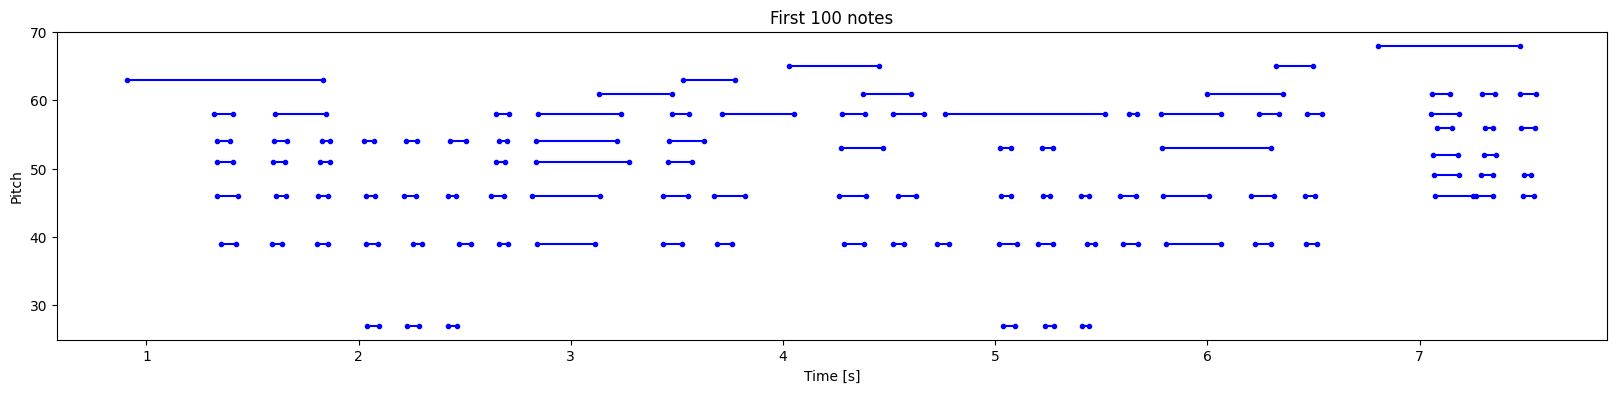

In [19]:
plot_piano_roll(raw_notes, count=100)

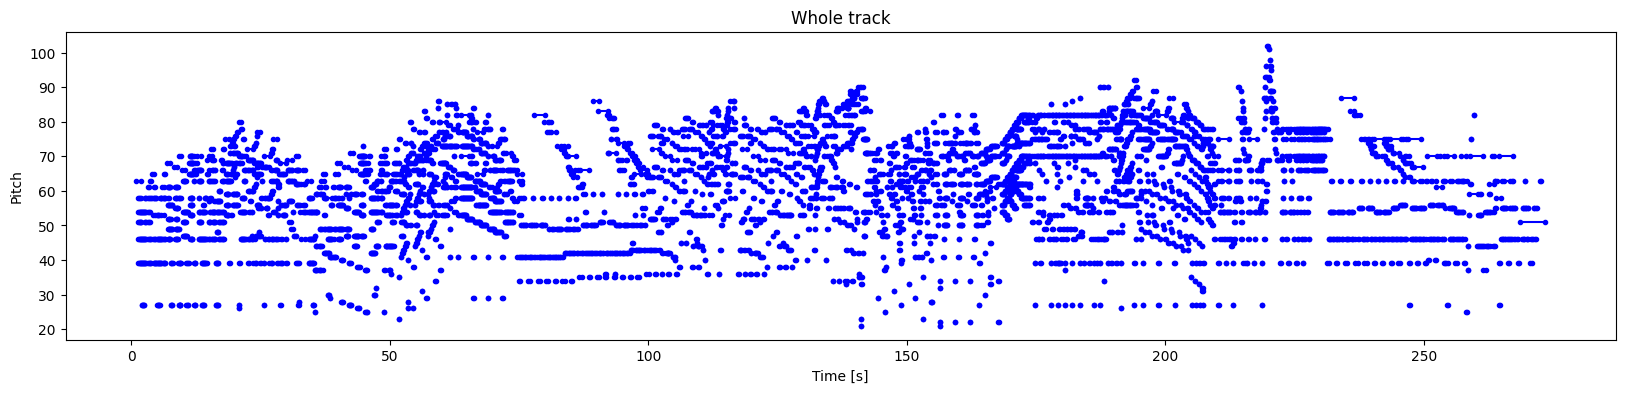

In [20]:
plot_piano_roll(raw_notes)

In [21]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

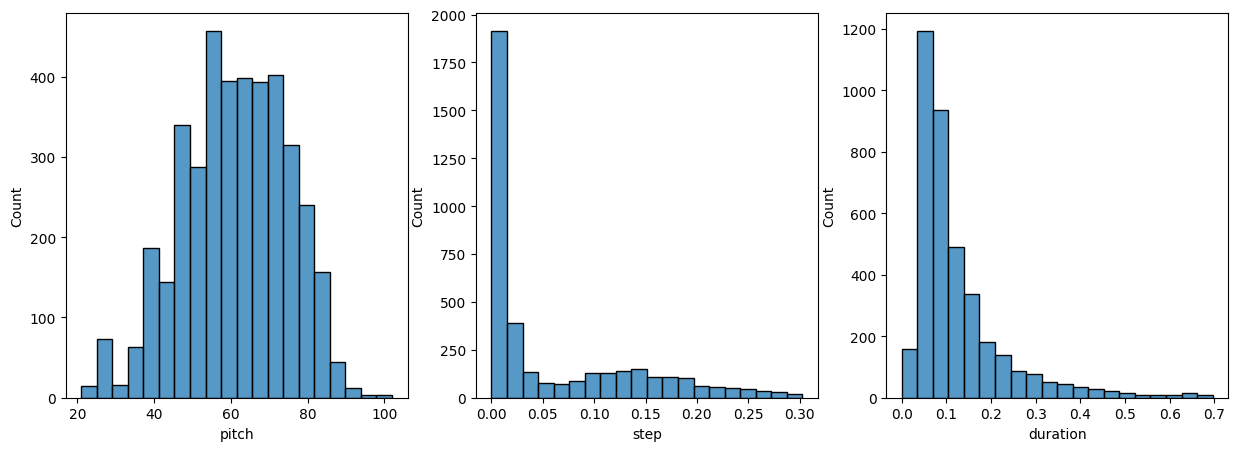

In [22]:
plot_distributions(raw_notes)

In [23]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [24]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [25]:
display_audio(example_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [26]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [27]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 15315


In [28]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [29]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [30]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [31]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [32]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.625      0.         0.23828125]
 [0.6015625  0.04036458 0.2421875 ]
 [0.5859375  0.22395833 0.06510417]
 [0.5625     0.09505208 0.0703125 ]
 [0.53125    0.11067708 0.1640625 ]
 [0.5859375  0.05598958 0.12760417]
 [0.5625     0.09244792 0.08333333]
 [0.625      0.08333333 0.17317708]
 [0.6015625  0.01822917 0.15104167]
 [0.5859375  0.109375   0.04036458]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=68.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.11588541666666652>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.15494791666666696>}


In [33]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [34]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [35]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [36]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            


 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             


 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                


 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                


 step (Dense)                (None, 1)                    129       ['lstm[0][0]']                


Total params: 84354 (329.51 KB)


Trainable params: 84354 (329.51 KB)


Non-trainable params: 0 (0.00 Byte)


__________________________________________________________________________________________________


In [37]:
losses = model.evaluate(train_ds, return_dict=True)
losses


      1/Unknown - 3s 3s/step - loss: 6.2279 - duration_loss: 0.7264 - pitch_loss: 4.8595 - step_loss: 0.6420


     19/Unknown - 3s 3ms/step - loss: 6.3166 - duration_loss: 0.7402 - pitch_loss: 4.8553 - step_loss: 0.7211


     38/Unknown - 3s 3ms/step - loss: 6.2207 - duration_loss: 0.6496 - pitch_loss: 4.8551 - step_loss: 0.7160


     57/Unknown - 3s 3ms/step - loss: 6.1262 - duration_loss: 0.5841 - pitch_loss: 4.8542 - step_loss: 0.6879


     76/Unknown - 3s 3ms/step - loss: 6.2462 - duration_loss: 0.7150 - pitch_loss: 4.8544 - step_loss: 0.6768


     95/Unknown - 3s 3ms/step - loss: 6.2315 - duration_loss: 0.6930 - pitch_loss: 4.8542 - step_loss: 0.6844


    115/Unknown - 3s 3ms/step - loss: 6.2007 - duration_loss: 0.6628 - pitch_loss: 4.8540 - step_loss: 0.6839


    134/Unknown - 3s 3ms/step - loss: 6.1725 - duration_loss: 0.6322 - pitch_loss: 4.8541 - step_loss: 0.6862


    154/Unknown - 3s 3ms/step - loss: 6.1698 - duration_loss: 0.6366 - pitch_loss: 4.8542 - step_loss: 0.6790


    173/Unknown - 3s 3ms/step - loss: 6.1571 - duration_loss: 0.6253 - pitch_loss: 4.8544 - step_loss: 0.6774


    193/Unknown - 3s 3ms/step - loss: 6.1567 - duration_loss: 0.6281 - pitch_loss: 4.8543 - step_loss: 0.6742


    213/Unknown - 4s 3ms/step - loss: 6.1349 - duration_loss: 0.6098 - pitch_loss: 4.8543 - step_loss: 0.6708


    232/Unknown - 4s 3ms/step - loss: 6.1322 - duration_loss: 0.6080 - pitch_loss: 4.8544 - step_loss: 0.6698


238/238 [==============================] - 4s 3ms/step - loss: 6.1272 - duration_loss: 0.6039 - pitch_loss: 4.8544 - step_loss: 0.6689


{'loss': 6.127169609069824,
 'duration_loss': 0.603919267654419,
 'pitch_loss': 4.854353427886963,
 'step_loss': 0.6688962578773499}

In [38]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [39]:
model.evaluate(train_ds, return_dict=True)


      1/Unknown - 1s 852ms/step - loss: 1.6113 - duration_loss: 0.7264 - pitch_loss: 4.8595 - step_loss: 0.6420


     19/Unknown - 1s 3ms/step - loss: 1.7041 - duration_loss: 0.7402 - pitch_loss: 4.8553 - step_loss: 0.7211  


     38/Unknown - 1s 3ms/step - loss: 1.6083 - duration_loss: 0.6496 - pitch_loss: 4.8551 - step_loss: 0.7160


     56/Unknown - 1s 3ms/step - loss: 1.5202 - duration_loss: 0.5883 - pitch_loss: 4.8543 - step_loss: 0.6892


     74/Unknown - 1s 3ms/step - loss: 1.5717 - duration_loss: 0.6508 - pitch_loss: 4.8543 - step_loss: 0.6782


     92/Unknown - 1s 3ms/step - loss: 1.6320 - duration_loss: 0.7031 - pitch_loss: 4.8541 - step_loss: 0.6862


    110/Unknown - 1s 3ms/step - loss: 1.5971 - duration_loss: 0.6757 - pitch_loss: 4.8542 - step_loss: 0.6787


    129/Unknown - 1s 3ms/step - loss: 1.5699 - duration_loss: 0.6385 - pitch_loss: 4.8541 - step_loss: 0.6886


    147/Unknown - 1s 3ms/step - loss: 1.5422 - duration_loss: 0.6181 - pitch_loss: 4.8541 - step_loss: 0.6814


    166/Unknown - 1s 3ms/step - loss: 1.5491 - duration_loss: 0.6275 - pitch_loss: 4.8543 - step_loss: 0.6788


    184/Unknown - 1s 3ms/step - loss: 1.5347 - duration_loss: 0.6170 - pitch_loss: 4.8543 - step_loss: 0.6750


    202/Unknown - 1s 3ms/step - loss: 1.5347 - duration_loss: 0.6193 - pitch_loss: 4.8543 - step_loss: 0.6726


    220/Unknown - 1s 3ms/step - loss: 1.5230 - duration_loss: 0.6099 - pitch_loss: 4.8543 - step_loss: 0.6704


238/238 [==============================] - 2s 3ms/step - loss: 1.5155 - duration_loss: 0.6039 - pitch_loss: 4.8544 - step_loss: 0.6689


{'loss': 1.515533447265625,
 'duration_loss': 0.603919267654419,
 'pitch_loss': 4.854353427886963,
 'step_loss': 0.6688962578773499}

In [40]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [41]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50


I0000 00:00:1698385783.436050  470386 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



      1/Unknown - 3s 3s/step - loss: 1.6113 - duration_loss: 0.7264 - pitch_loss: 4.8595 - step_loss: 0.6420


     12/Unknown - 3s 5ms/step - loss: 0.9619 - duration_loss: 0.4725 - pitch_loss: 4.7879 - step_loss: 0.2499


     24/Unknown - 3s 5ms/step - loss: 0.7161 - duration_loss: 0.3150 - pitch_loss: 4.7369 - step_loss: 0.1643


     36/Unknown - 3s 5ms/step - loss: 0.6782 - duration_loss: 0.3090 - pitch_loss: 4.6849 - step_loss: 0.1350


     48/Unknown - 3s 5ms/step - loss: 0.6141 - duration_loss: 0.2756 - pitch_loss: 4.6355 - step_loss: 0.1068


     60/Unknown - 3s 4ms/step - loss: 0.5554 - duration_loss: 0.2374 - pitch_loss: 4.5867 - step_loss: 0.0887


     72/Unknown - 3s 4ms/step - loss: 0.5866 - duration_loss: 0.2822 - pitch_loss: 4.5376 - step_loss: 0.0776


     84/Unknown - 3s 4ms/step - loss: 0.5916 - duration_loss: 0.2957 - pitch_loss: 4.4954 - step_loss: 0.0711


     96/Unknown - 3s 4ms/step - loss: 0.5848 - duration_loss: 0.2857 - pitch_loss: 4.4632 - step_loss: 0.0759


    108/Unknown - 3s 4ms/step - loss: 0.5727 - duration_loss: 0.2808 - pitch_loss: 4.4347 - step_loss: 0.0701


    120/Unknown - 3s 4ms/step - loss: 0.5644 - duration_loss: 0.2634 - pitch_loss: 4.4027 - step_loss: 0.0809


    133/Unknown - 3s 4ms/step - loss: 0.5398 - duration_loss: 0.2462 - pitch_loss: 4.3736 - step_loss: 0.0749


    145/Unknown - 3s 4ms/step - loss: 0.5226 - duration_loss: 0.2343 - pitch_loss: 4.3511 - step_loss: 0.0707


    157/Unknown - 4s 4ms/step - loss: 0.5274 - duration_loss: 0.2443 - pitch_loss: 4.3326 - step_loss: 0.0665


    170/Unknown - 4s 4ms/step - loss: 0.5240 - duration_loss: 0.2440 - pitch_loss: 4.3190 - step_loss: 0.0640


    183/Unknown - 4s 4ms/step - loss: 0.5090 - duration_loss: 0.2326 - pitch_loss: 4.3080 - step_loss: 0.0609


    196/Unknown - 4s 4ms/step - loss: 0.5153 - duration_loss: 0.2419 - pitch_loss: 4.2967 - step_loss: 0.0586


    208/Unknown - 4s 4ms/step - loss: 0.5059 - duration_loss: 0.2355 - pitch_loss: 4.2841 - step_loss: 0.0563


    221/Unknown - 4s 4ms/step - loss: 0.4985 - duration_loss: 0.2304 - pitch_loss: 4.2721 - step_loss: 0.0544


    234/Unknown - 4s 4ms/step - loss: 0.4922 - duration_loss: 0.2256 - pitch_loss: 4.2603 - step_loss: 0.0537


238/238 [==============================] - 4s 5ms/step - loss: 0.4896 - duration_loss: 0.2237 - pitch_loss: 4.2569 - step_loss: 0.0530


Epoch 2/50



  1/238 [..............................] - ETA: 1s - loss: 0.5822 - duration_loss: 0.3656 - pitch_loss: 4.0392 - step_loss: 0.0146


 13/238 [>.............................] - ETA: 0s - loss: 0.6068 - duration_loss: 0.2678 - pitch_loss: 4.0370 - step_loss: 0.1371


 26/238 [==>...........................] - ETA: 0s - loss: 0.4860 - duration_loss: 0.1841 - pitch_loss: 4.0783 - step_loss: 0.0980


 38/238 [===>..........................] - ETA: 0s - loss: 0.5261 - duration_loss: 0.2306 - pitch_loss: 4.0937 - step_loss: 0.0909


 50/238 [=====>........................] - ETA: 0s - loss: 0.4850 - duration_loss: 0.2077 - pitch_loss: 4.0992 - step_loss: 0.0724


 62/238 [======>.......................] - ETA: 0s - loss: 0.4475 - duration_loss: 0.1814 - pitch_loss: 4.0968 - step_loss: 0.0612


 75/238 [========>.....................] - ETA: 0s - loss: 0.4869 - duration_loss: 0.2273 - pitch_loss: 4.0966 - step_loss: 0.0548


 87/238 [=========>....................] - ETA: 0s - loss: 0.5005 - duration_loss: 0.2329 - pitch_loss: 4.0949 - step_loss: 0.0629


 99/238 [===========>..................] - ETA: 0s - loss: 0.4925 - duration_loss: 0.2299 - pitch_loss: 4.0931 - step_loss: 0.0580


111/238 [============>.................] - ETA: 0s - loss: 0.4889 - duration_loss: 0.2296 - pitch_loss: 4.0913 - step_loss: 0.0547


123/238 [==============>...............] - ETA: 0s - loss: 0.4886 - duration_loss: 0.2170 - pitch_loss: 4.0838 - step_loss: 0.0674


136/238 [================>.............] - ETA: 0s - loss: 0.4730 - duration_loss: 0.2062 - pitch_loss: 4.0814 - step_loss: 0.0627


148/238 [=================>............] - ETA: 0s - loss: 0.4606 - duration_loss: 0.1973 - pitch_loss: 4.0805 - step_loss: 0.0592


161/238 [===================>..........] - ETA: 0s - loss: 0.4726 - duration_loss: 0.2128 - pitch_loss: 4.0799 - step_loss: 0.0558


174/238 [====================>.........] - ETA: 0s - loss: 0.4679 - duration_loss: 0.2097 - pitch_loss: 4.0810 - step_loss: 0.0541


187/238 [======================>.......] - ETA: 0s - loss: 0.4570 - duration_loss: 0.2011 - pitch_loss: 4.0814 - step_loss: 0.0518


200/238 [========================>.....] - ETA: 0s - loss: 0.4674 - duration_loss: 0.2132 - pitch_loss: 4.0811 - step_loss: 0.0502


213/238 [=========================>....] - ETA: 0s - loss: 0.4587 - duration_loss: 0.2066 - pitch_loss: 4.0779 - step_loss: 0.0483


225/238 [===========================>..] - ETA: 0s - loss: 0.4562 - duration_loss: 0.2056 - pitch_loss: 4.0773 - step_loss: 0.0467


238/238 [==============================] - ETA: 0s - loss: 0.4510 - duration_loss: 0.2010 - pitch_loss: 4.0747 - step_loss: 0.0463


238/238 [==============================] - 1s 4ms/step - loss: 0.4510 - duration_loss: 0.2010 - pitch_loss: 4.0747 - step_loss: 0.0463


Epoch 3/50



  1/238 [..............................] - ETA: 1s - loss: 0.5760 - duration_loss: 0.3605 - pitch_loss: 4.0178 - step_loss: 0.0147


 13/238 [>.............................] - ETA: 0s - loss: 0.6024 - duration_loss: 0.2696 - pitch_loss: 4.0182 - step_loss: 0.1319


 26/238 [==>...........................] - ETA: 0s - loss: 0.4812 - duration_loss: 0.1840 - pitch_loss: 4.0576 - step_loss: 0.0943


 39/238 [===>..........................] - ETA: 0s - loss: 0.5153 - duration_loss: 0.2259 - pitch_loss: 4.0697 - step_loss: 0.0859


 51/238 [=====>........................] - ETA: 0s - loss: 0.4762 - duration_loss: 0.2038 - pitch_loss: 4.0695 - step_loss: 0.0689


 63/238 [======>.......................] - ETA: 0s - loss: 0.4428 - duration_loss: 0.1807 - pitch_loss: 4.0675 - step_loss: 0.0587


 76/238 [========>.....................] - ETA: 0s - loss: 0.4798 - duration_loss: 0.2232 - pitch_loss: 4.0689 - step_loss: 0.0532


 88/238 [==========>...................] - ETA: 0s - loss: 0.4912 - duration_loss: 0.2265 - pitch_loss: 4.0677 - step_loss: 0.0613


100/238 [===========>..................] - ETA: 0s - loss: 0.4870 - duration_loss: 0.2266 - pitch_loss: 4.0690 - step_loss: 0.0569


112/238 [=============>................] - ETA: 0s - loss: 0.4825 - duration_loss: 0.2258 - pitch_loss: 4.0677 - step_loss: 0.0532


125/238 [==============>...............] - ETA: 0s - loss: 0.4804 - duration_loss: 0.2119 - pitch_loss: 4.0623 - step_loss: 0.0653


138/238 [================>.............] - ETA: 0s - loss: 0.4689 - duration_loss: 0.2045 - pitch_loss: 4.0618 - step_loss: 0.0614


151/238 [==================>...........] - ETA: 0s - loss: 0.4695 - duration_loss: 0.2085 - pitch_loss: 4.0619 - step_loss: 0.0579


163/238 [===================>..........] - ETA: 0s - loss: 0.4688 - duration_loss: 0.2109 - pitch_loss: 4.0635 - step_loss: 0.0547


176/238 [=====================>........] - ETA: 0s - loss: 0.4642 - duration_loss: 0.2079 - pitch_loss: 4.0649 - step_loss: 0.0530


188/238 [======================>.......] - ETA: 0s - loss: 0.4546 - duration_loss: 0.2003 - pitch_loss: 4.0644 - step_loss: 0.0511


201/238 [========================>.....] - ETA: 0s - loss: 0.4643 - duration_loss: 0.2118 - pitch_loss: 4.0645 - step_loss: 0.0493


214/238 [=========================>....] - ETA: 0s - loss: 0.4561 - duration_loss: 0.2055 - pitch_loss: 4.0623 - step_loss: 0.0475


226/238 [===========================>..] - ETA: 0s - loss: 0.4538 - duration_loss: 0.2047 - pitch_loss: 4.0618 - step_loss: 0.0460


238/238 [==============================] - 1s 4ms/step - loss: 0.4494 - duration_loss: 0.2006 - pitch_loss: 4.0595 - step_loss: 0.0457


Epoch 4/50



  1/238 [..............................] - ETA: 1s - loss: 0.5743 - duration_loss: 0.3591 - pitch_loss: 4.0095 - step_loss: 0.0147


 13/238 [>.............................] - ETA: 0s - loss: 0.6073 - duration_loss: 0.2776 - pitch_loss: 4.0091 - step_loss: 0.1293


 25/238 [==>...........................] - ETA: 0s - loss: 0.4919 - duration_loss: 0.1945 - pitch_loss: 4.0471 - step_loss: 0.0950


 37/238 [===>..........................] - ETA: 0s - loss: 0.5271 - duration_loss: 0.2369 - pitch_loss: 4.0551 - step_loss: 0.0874


 49/238 [=====>........................] - ETA: 0s - loss: 0.4837 - duration_loss: 0.2105 - pitch_loss: 4.0605 - step_loss: 0.0701


 62/238 [======>.......................] - ETA: 0s - loss: 0.4432 - duration_loss: 0.1819 - pitch_loss: 4.0568 - step_loss: 0.0585


 74/238 [========>.....................] - ETA: 0s - loss: 0.4703 - duration_loss: 0.2148 - pitch_loss: 4.0560 - step_loss: 0.0527


 87/238 [=========>....................] - ETA: 0s - loss: 0.4866 - duration_loss: 0.2228 - pitch_loss: 4.0571 - step_loss: 0.0609


100/238 [===========>..................] - ETA: 0s - loss: 0.4845 - duration_loss: 0.2257 - pitch_loss: 4.0576 - step_loss: 0.0559


112/238 [=============>................] - ETA: 0s - loss: 0.4789 - duration_loss: 0.2239 - pitch_loss: 4.0553 - step_loss: 0.0522


125/238 [==============>...............] - ETA: 0s - loss: 0.4772 - duration_loss: 0.2098 - pitch_loss: 4.0489 - step_loss: 0.0649


138/238 [================>.............] - ETA: 0s - loss: 0.4649 - duration_loss: 0.2020 - pitch_loss: 4.0473 - step_loss: 0.0605


150/238 [=================>............] - ETA: 0s - loss: 0.4530 - duration_loss: 0.1934 - pitch_loss: 4.0465 - step_loss: 0.0573


163/238 [===================>..........] - ETA: 0s - loss: 0.4646 - duration_loss: 0.2082 - pitch_loss: 4.0480 - step_loss: 0.0539


176/238 [=====================>........] - ETA: 0s - loss: 0.4601 - duration_loss: 0.2052 - pitch_loss: 4.0499 - step_loss: 0.0523


189/238 [======================>.......] - ETA: 0s - loss: 0.4496 - duration_loss: 0.1969 - pitch_loss: 4.0496 - step_loss: 0.0502


202/238 [========================>.....] - ETA: 0s - loss: 0.4597 - duration_loss: 0.2088 - pitch_loss: 4.0501 - step_loss: 0.0484


214/238 [=========================>....] - ETA: 0s - loss: 0.4527 - duration_loss: 0.2035 - pitch_loss: 4.0482 - step_loss: 0.0468


226/238 [===========================>..] - ETA: 0s - loss: 0.4507 - duration_loss: 0.2029 - pitch_loss: 4.0478 - step_loss: 0.0454


238/238 [==============================] - ETA: 0s - loss: 0.4464 - duration_loss: 0.1989 - pitch_loss: 4.0458 - step_loss: 0.0451


238/238 [==============================] - 1s 4ms/step - loss: 0.4464 - duration_loss: 0.1989 - pitch_loss: 4.0458 - step_loss: 0.0451


Epoch 5/50



  1/238 [..............................] - ETA: 1s - loss: 0.5719 - duration_loss: 0.3574 - pitch_loss: 3.9972 - step_loss: 0.0147


 13/238 [>.............................] - ETA: 0s - loss: 0.5775 - duration_loss: 0.2498 - pitch_loss: 3.9977 - step_loss: 0.1278


 25/238 [==>...........................] - ETA: 0s - loss: 0.4727 - duration_loss: 0.1770 - pitch_loss: 4.0361 - step_loss: 0.0939


 38/238 [===>..........................] - ETA: 0s - loss: 0.5075 - duration_loss: 0.2197 - pitch_loss: 4.0479 - step_loss: 0.0854


 51/238 [=====>........................] - ETA: 0s - loss: 0.4646 - duration_loss: 0.1951 - pitch_loss: 4.0485 - step_loss: 0.0671


 64/238 [=======>......................] - ETA: 0s - loss: 0.4308 - duration_loss: 0.1721 - pitch_loss: 4.0467 - step_loss: 0.0564


 77/238 [========>.....................] - ETA: 0s - loss: 0.4602 - duration_loss: 0.2070 - pitch_loss: 4.0468 - step_loss: 0.0509


 89/238 [==========>...................] - ETA: 0s - loss: 0.4723 - duration_loss: 0.2107 - pitch_loss: 4.0464 - step_loss: 0.0593


101/238 [===========>..................] - ETA: 0s - loss: 0.4714 - duration_loss: 0.2141 - pitch_loss: 4.0468 - step_loss: 0.0549


113/238 [=============>................] - ETA: 0s - loss: 0.4678 - duration_loss: 0.2142 - pitch_loss: 4.0430 - step_loss: 0.0514


125/238 [==============>...............] - ETA: 0s - loss: 0.4684 - duration_loss: 0.2021 - pitch_loss: 4.0375 - step_loss: 0.0644


138/238 [================>.............] - ETA: 0s - loss: 0.4573 - duration_loss: 0.1955 - pitch_loss: 4.0355 - step_loss: 0.0600


151/238 [==================>...........] - ETA: 0s - loss: 0.4578 - duration_loss: 0.1995 - pitch_loss: 4.0354 - step_loss: 0.0565


164/238 [===================>..........] - ETA: 0s - loss: 0.4618 - duration_loss: 0.2056 - pitch_loss: 4.0371 - step_loss: 0.0543


177/238 [=====================>........] - ETA: 0s - loss: 0.4522 - duration_loss: 0.1986 - pitch_loss: 4.0386 - step_loss: 0.0517


190/238 [======================>.......] - ETA: 0s - loss: 0.4423 - duration_loss: 0.1907 - pitch_loss: 4.0386 - step_loss: 0.0496


203/238 [========================>.....] - ETA: 0s - loss: 0.4533 - duration_loss: 0.2035 - pitch_loss: 4.0383 - step_loss: 0.0479


216/238 [==========================>...] - ETA: 0s - loss: 0.4458 - duration_loss: 0.1976 - pitch_loss: 4.0366 - step_loss: 0.0464


229/238 [===========================>..] - ETA: 0s - loss: 0.4451 - duration_loss: 0.1987 - pitch_loss: 4.0349 - step_loss: 0.0447


238/238 [==============================] - 1s 4ms/step - loss: 0.4413 - duration_loss: 0.1948 - pitch_loss: 4.0342 - step_loss: 0.0448


Epoch 6/50



  1/238 [..............................] - ETA: 1s - loss: 0.5693 - duration_loss: 0.3556 - pitch_loss: 3.9799 - step_loss: 0.0147


 14/238 [>.............................] - ETA: 0s - loss: 0.5539 - duration_loss: 0.2343 - pitch_loss: 3.9793 - step_loss: 0.1207


 26/238 [==>...........................] - ETA: 0s - loss: 0.4499 - duration_loss: 0.1583 - pitch_loss: 4.0153 - step_loss: 0.0908


 39/238 [===>..........................] - ETA: 0s - loss: 0.4910 - duration_loss: 0.2067 - pitch_loss: 4.0269 - step_loss: 0.0829


 51/238 [=====>........................] - ETA: 0s - loss: 0.4560 - duration_loss: 0.1882 - pitch_loss: 4.0229 - step_loss: 0.0666


 63/238 [======>.......................] - ETA: 0s - loss: 0.4266 - duration_loss: 0.1689 - pitch_loss: 4.0178 - step_loss: 0.0568


 75/238 [========>.....................] - ETA: 0s - loss: 0.4539 - duration_loss: 0.2015 - pitch_loss: 4.0166 - step_loss: 0.0516


 86/238 [=========>....................] - ETA: 0s - loss: 0.4552 - duration_loss: 0.2060 - pitch_loss: 4.0163 - step_loss: 0.0485


 98/238 [===========>..................] - ETA: 0s - loss: 0.4652 - duration_loss: 0.2092 - pitch_loss: 4.0196 - step_loss: 0.0550


110/238 [============>.................] - ETA: 0s - loss: 0.4627 - duration_loss: 0.2099 - pitch_loss: 4.0206 - step_loss: 0.0518


122/238 [==============>...............] - ETA: 0s - loss: 0.4639 - duration_loss: 0.1984 - pitch_loss: 4.0125 - step_loss: 0.0649


134/238 [===============>..............] - ETA: 0s - loss: 0.4513 - duration_loss: 0.1898 - pitch_loss: 4.0173 - step_loss: 0.0606


146/238 [=================>............] - ETA: 0s - loss: 0.4410 - duration_loss: 0.1827 - pitch_loss: 4.0187 - step_loss: 0.0573


159/238 [===================>..........] - ETA: 0s - loss: 0.4511 - duration_loss: 0.1961 - pitch_loss: 4.0215 - step_loss: 0.0540


171/238 [====================>.........] - ETA: 0s - loss: 0.4516 - duration_loss: 0.1978 - pitch_loss: 4.0239 - step_loss: 0.0526


184/238 [======================>.......] - ETA: 0s - loss: 0.4411 - duration_loss: 0.1895 - pitch_loss: 4.0259 - step_loss: 0.0503


196/238 [=======================>......] - ETA: 0s - loss: 0.4524 - duration_loss: 0.2022 - pitch_loss: 4.0283 - step_loss: 0.0489


208/238 [=========================>....] - ETA: 0s - loss: 0.4463 - duration_loss: 0.1980 - pitch_loss: 4.0276 - step_loss: 0.0469


220/238 [==========================>...] - ETA: 0s - loss: 0.4384 - duration_loss: 0.1914 - pitch_loss: 4.0286 - step_loss: 0.0456


233/238 [============================>.] - ETA: 0s - loss: 0.4383 - duration_loss: 0.1915 - pitch_loss: 4.0273 - step_loss: 0.0454


238/238 [==============================] - 1s 4ms/step - loss: 0.4357 - duration_loss: 0.1896 - pitch_loss: 4.0273 - step_loss: 0.0447


Epoch 7/50



  1/238 [..............................] - ETA: 1s - loss: 0.5717 - duration_loss: 0.3573 - pitch_loss: 3.9977 - step_loss: 0.0145


 14/238 [>.............................] - ETA: 0s - loss: 0.5464 - duration_loss: 0.2307 - pitch_loss: 3.9950 - step_loss: 0.1159


 26/238 [==>...........................] - ETA: 0s - loss: 0.4458 - duration_loss: 0.1565 - pitch_loss: 4.0341 - step_loss: 0.0876


 38/238 [===>..........................] - ETA: 0s - loss: 0.4936 - duration_loss: 0.2088 - pitch_loss: 4.0425 - step_loss: 0.0826


 50/238 [=====>........................] - ETA: 0s - loss: 0.4584 - duration_loss: 0.1903 - pitch_loss: 4.0423 - step_loss: 0.0660


 63/238 [======>.......................] - ETA: 0s - loss: 0.4268 - duration_loss: 0.1694 - pitch_loss: 4.0382 - step_loss: 0.0555


 76/238 [========>.....................] - ETA: 0s - loss: 0.4511 - duration_loss: 0.1993 - pitch_loss: 4.0387 - step_loss: 0.0498


 89/238 [==========>...................] - ETA: 0s - loss: 0.4603 - duration_loss: 0.2007 - pitch_loss: 4.0383 - step_loss: 0.0576


102/238 [===========>..................] - ETA: 0s - loss: 0.4570 - duration_loss: 0.2020 - pitch_loss: 4.0371 - step_loss: 0.0531


115/238 [=============>................] - ETA: 0s - loss: 0.4588 - duration_loss: 0.2005 - pitch_loss: 4.0325 - step_loss: 0.0567


128/238 [===============>..............] - ETA: 0s - loss: 0.4532 - duration_loss: 0.1895 - pitch_loss: 4.0278 - step_loss: 0.0623


141/238 [================>.............] - ETA: 0s - loss: 0.4432 - duration_loss: 0.1840 - pitch_loss: 4.0240 - step_loss: 0.0580


154/238 [==================>...........] - ETA: 0s - loss: 0.4516 - duration_loss: 0.1956 - pitch_loss: 4.0245 - step_loss: 0.0548


167/238 [====================>.........] - ETA: 0s - loss: 0.4508 - duration_loss: 0.1967 - pitch_loss: 4.0251 - step_loss: 0.0529


180/238 [=====================>........] - ETA: 0s - loss: 0.4412 - duration_loss: 0.1893 - pitch_loss: 4.0271 - step_loss: 0.0506


193/238 [=======================>......] - ETA: 0s - loss: 0.4517 - duration_loss: 0.2015 - pitch_loss: 4.0281 - step_loss: 0.0488


206/238 [========================>.....] - ETA: 0s - loss: 0.4428 - duration_loss: 0.1949 - pitch_loss: 4.0261 - step_loss: 0.0466


218/238 [==========================>...] - ETA: 0s - loss: 0.4385 - duration_loss: 0.1918 - pitch_loss: 4.0254 - step_loss: 0.0454


231/238 [============================>.] - ETA: 0s - loss: 0.4375 - duration_loss: 0.1913 - pitch_loss: 4.0237 - step_loss: 0.0450


238/238 [==============================] - 1s 4ms/step - loss: 0.4338 - duration_loss: 0.1884 - pitch_loss: 4.0228 - step_loss: 0.0442


Epoch 8/50



  1/238 [..............................] - ETA: 1s - loss: 0.5649 - duration_loss: 0.3522 - pitch_loss: 3.9718 - step_loss: 0.0142


 14/238 [>.............................] - ETA: 0s - loss: 0.5064 - duration_loss: 0.1993 - pitch_loss: 3.9628 - step_loss: 0.1090


 27/238 [==>...........................] - ETA: 0s - loss: 0.4167 - duration_loss: 0.1349 - pitch_loss: 4.0031 - step_loss: 0.0817


 40/238 [====>.........................] - ETA: 0s - loss: 0.4674 - duration_loss: 0.1907 - pitch_loss: 4.0067 - step_loss: 0.0763


 53/238 [=====>........................] - ETA: 0s - loss: 0.4389 - duration_loss: 0.1776 - pitch_loss: 4.0017 - step_loss: 0.0612


 66/238 [=======>......................] - ETA: 0s - loss: 0.4147 - duration_loss: 0.1627 - pitch_loss: 4.0018 - step_loss: 0.0520


 78/238 [========>.....................] - ETA: 0s - loss: 0.4435 - duration_loss: 0.1959 - pitch_loss: 4.0001 - step_loss: 0.0476


 90/238 [==========>...................] - ETA: 0s - loss: 0.4440 - duration_loss: 0.1883 - pitch_loss: 3.9967 - step_loss: 0.0558


102/238 [===========>..................] - ETA: 0s - loss: 0.4404 - duration_loss: 0.1890 - pitch_loss: 3.9933 - step_loss: 0.0517


115/238 [=============>................] - ETA: 0s - loss: 0.4435 - duration_loss: 0.1891 - pitch_loss: 3.9869 - step_loss: 0.0551


128/238 [===============>..............] - ETA: 0s - loss: 0.4390 - duration_loss: 0.1793 - pitch_loss: 3.9838 - step_loss: 0.0605


141/238 [================>.............] - ETA: 0s - loss: 0.4311 - duration_loss: 0.1755 - pitch_loss: 3.9824 - step_loss: 0.0565


154/238 [==================>...........] - ETA: 0s - loss: 0.4403 - duration_loss: 0.1878 - pitch_loss: 3.9854 - step_loss: 0.0532


167/238 [====================>.........] - ETA: 0s - loss: 0.4400 - duration_loss: 0.1893 - pitch_loss: 3.9881 - step_loss: 0.0513


180/238 [=====================>........] - ETA: 0s - loss: 0.4309 - duration_loss: 0.1821 - pitch_loss: 3.9917 - step_loss: 0.0492


193/238 [=======================>......] - ETA: 0s - loss: 0.4413 - duration_loss: 0.1940 - pitch_loss: 3.9943 - step_loss: 0.0475


206/238 [========================>.....] - ETA: 0s - loss: 0.4326 - duration_loss: 0.1876 - pitch_loss: 3.9933 - step_loss: 0.0454


218/238 [==========================>...] - ETA: 0s - loss: 0.4282 - duration_loss: 0.1843 - pitch_loss: 3.9934 - step_loss: 0.0442


231/238 [============================>.] - ETA: 0s - loss: 0.4284 - duration_loss: 0.1848 - pitch_loss: 3.9926 - step_loss: 0.0440


238/238 [==============================] - 1s 4ms/step - loss: 0.4249 - duration_loss: 0.1821 - pitch_loss: 3.9918 - step_loss: 0.0432


Epoch 9/50



  1/238 [..............................] - ETA: 1s - loss: 0.5655 - duration_loss: 0.3539 - pitch_loss: 3.9487 - step_loss: 0.0142


 13/238 [>.............................] - ETA: 0s - loss: 0.4902 - duration_loss: 0.1847 - pitch_loss: 3.9416 - step_loss: 0.1084


 26/238 [==>...........................] - ETA: 0s - loss: 0.4134 - duration_loss: 0.1339 - pitch_loss: 3.9749 - step_loss: 0.0808


 39/238 [===>..........................] - ETA: 0s - loss: 0.4644 - duration_loss: 0.1899 - pitch_loss: 3.9808 - step_loss: 0.0755


 52/238 [=====>........................] - ETA: 0s - loss: 0.4352 - duration_loss: 0.1762 - pitch_loss: 3.9757 - step_loss: 0.0602


 65/238 [=======>......................] - ETA: 0s - loss: 0.4068 - duration_loss: 0.1568 - pitch_loss: 3.9753 - step_loss: 0.0512


 78/238 [========>.....................] - ETA: 0s - loss: 0.4348 - duration_loss: 0.1900 - pitch_loss: 3.9701 - step_loss: 0.0463


 91/238 [==========>...................] - ETA: 0s - loss: 0.4400 - duration_loss: 0.1873 - pitch_loss: 3.9645 - step_loss: 0.0545


104/238 [============>.................] - ETA: 0s - loss: 0.4276 - duration_loss: 0.1794 - pitch_loss: 3.9628 - step_loss: 0.0500


117/238 [=============>................] - ETA: 0s - loss: 0.4341 - duration_loss: 0.1824 - pitch_loss: 3.9589 - step_loss: 0.0537


130/238 [===============>..............] - ETA: 0s - loss: 0.4299 - duration_loss: 0.1737 - pitch_loss: 3.9638 - step_loss: 0.0580


143/238 [=================>............] - ETA: 0s - loss: 0.4211 - duration_loss: 0.1685 - pitch_loss: 3.9664 - step_loss: 0.0542


155/238 [==================>...........] - ETA: 0s - loss: 0.4314 - duration_loss: 0.1816 - pitch_loss: 3.9677 - step_loss: 0.0514


168/238 [====================>.........] - ETA: 0s - loss: 0.4335 - duration_loss: 0.1850 - pitch_loss: 3.9721 - step_loss: 0.0498


181/238 [=====================>........] - ETA: 0s - loss: 0.4247 - duration_loss: 0.1780 - pitch_loss: 3.9762 - step_loss: 0.0478


194/238 [=======================>......] - ETA: 0s - loss: 0.4349 - duration_loss: 0.1898 - pitch_loss: 3.9787 - step_loss: 0.0462


207/238 [=========================>....] - ETA: 0s - loss: 0.4298 - duration_loss: 0.1867 - pitch_loss: 3.9783 - step_loss: 0.0442


220/238 [==========================>...] - ETA: 0s - loss: 0.4213 - duration_loss: 0.1795 - pitch_loss: 3.9791 - step_loss: 0.0429


233/238 [============================>.] - ETA: 0s - loss: 0.4223 - duration_loss: 0.1807 - pitch_loss: 3.9779 - step_loss: 0.0427


238/238 [==============================] - 1s 4ms/step - loss: 0.4201 - duration_loss: 0.1790 - pitch_loss: 3.9779 - step_loss: 0.0422


Epoch 10/50



  1/238 [..............................] - ETA: 1s - loss: 0.5628 - duration_loss: 0.3514 - pitch_loss: 3.9397 - step_loss: 0.0145


 14/238 [>.............................] - ETA: 0s - loss: 0.4713 - duration_loss: 0.1738 - pitch_loss: 3.9323 - step_loss: 0.1008


 27/238 [==>...........................] - ETA: 0s - loss: 0.3970 - duration_loss: 0.1215 - pitch_loss: 3.9684 - step_loss: 0.0771


 40/238 [====>.........................] - ETA: 0s - loss: 0.4506 - duration_loss: 0.1800 - pitch_loss: 3.9653 - step_loss: 0.0723


 53/238 [=====>........................] - ETA: 0s - loss: 0.4256 - duration_loss: 0.1686 - pitch_loss: 3.9632 - step_loss: 0.0588


 66/238 [=======>......................] - ETA: 0s - loss: 0.3992 - duration_loss: 0.1509 - pitch_loss: 3.9649 - step_loss: 0.0500


 79/238 [========>.....................] - ETA: 0s - loss: 0.4256 - duration_loss: 0.1820 - pitch_loss: 3.9597 - step_loss: 0.0456


 92/238 [==========>...................] - ETA: 0s - loss: 0.4318 - duration_loss: 0.1810 - pitch_loss: 3.9572 - step_loss: 0.0530


105/238 [============>.................] - ETA: 0s - loss: 0.4278 - duration_loss: 0.1809 - pitch_loss: 3.9617 - step_loss: 0.0488


117/238 [=============>................] - ETA: 0s - loss: 0.4281 - duration_loss: 0.1776 - pitch_loss: 3.9583 - step_loss: 0.0525


130/238 [===============>..............] - ETA: 0s - loss: 0.4241 - duration_loss: 0.1692 - pitch_loss: 3.9592 - step_loss: 0.0569


143/238 [=================>............] - ETA: 0s - loss: 0.4155 - duration_loss: 0.1643 - pitch_loss: 3.9601 - step_loss: 0.0533


156/238 [==================>...........] - ETA: 0s - loss: 0.4262 - duration_loss: 0.1779 - pitch_loss: 3.9606 - step_loss: 0.0503


169/238 [====================>.........] - ETA: 0s - loss: 0.4278 - duration_loss: 0.1810 - pitch_loss: 3.9622 - step_loss: 0.0486


182/238 [=====================>........] - ETA: 0s - loss: 0.4190 - duration_loss: 0.1736 - pitch_loss: 3.9656 - step_loss: 0.0471


195/238 [=======================>......] - ETA: 0s - loss: 0.4260 - duration_loss: 0.1823 - pitch_loss: 3.9667 - step_loss: 0.0454


208/238 [=========================>....] - ETA: 0s - loss: 0.4230 - duration_loss: 0.1812 - pitch_loss: 3.9658 - step_loss: 0.0436


221/238 [==========================>...] - ETA: 0s - loss: 0.4193 - duration_loss: 0.1787 - pitch_loss: 3.9647 - step_loss: 0.0423


234/238 [============================>.] - ETA: 0s - loss: 0.4166 - duration_loss: 0.1762 - pitch_loss: 3.9639 - step_loss: 0.0422


238/238 [==============================] - 1s 4ms/step - loss: 0.4151 - duration_loss: 0.1753 - pitch_loss: 3.9627 - step_loss: 0.0417


Epoch 11/50



  1/238 [..............................] - ETA: 1s - loss: 0.5633 - duration_loss: 0.3554 - pitch_loss: 3.8870 - step_loss: 0.0135


 14/238 [>.............................] - ETA: 0s - loss: 0.4823 - duration_loss: 0.1821 - pitch_loss: 3.8791 - step_loss: 0.1062


 27/238 [==>...........................] - ETA: 0s - loss: 0.4021 - duration_loss: 0.1257 - pitch_loss: 3.9175 - step_loss: 0.0806


 40/238 [====>.........................] - ETA: 0s - loss: 0.4533 - duration_loss: 0.1821 - pitch_loss: 3.9259 - step_loss: 0.0749


 53/238 [=====>........................] - ETA: 0s - loss: 0.4276 - duration_loss: 0.1705 - pitch_loss: 3.9300 - step_loss: 0.0606


 66/238 [=======>......................] - ETA: 0s - loss: 0.4075 - duration_loss: 0.1579 - pitch_loss: 3.9348 - step_loss: 0.0529


 79/238 [========>.....................] - ETA: 0s - loss: 0.4323 - duration_loss: 0.1869 - pitch_loss: 3.9341 - step_loss: 0.0487


 92/238 [==========>...................] - ETA: 0s - loss: 0.4382 - duration_loss: 0.1850 - pitch_loss: 3.9311 - step_loss: 0.0566


105/238 [============>.................] - ETA: 0s - loss: 0.4336 - duration_loss: 0.1848 - pitch_loss: 3.9311 - step_loss: 0.0522


118/238 [=============>................] - ETA: 0s - loss: 0.4424 - duration_loss: 0.1827 - pitch_loss: 3.9284 - step_loss: 0.0633


131/238 [===============>..............] - ETA: 0s - loss: 0.4281 - duration_loss: 0.1731 - pitch_loss: 3.9286 - step_loss: 0.0587


144/238 [=================>............] - ETA: 0s - loss: 0.4199 - duration_loss: 0.1684 - pitch_loss: 3.9276 - step_loss: 0.0551


157/238 [==================>...........] - ETA: 0s - loss: 0.4302 - duration_loss: 0.1821 - pitch_loss: 3.9258 - step_loss: 0.0518


170/238 [====================>.........] - ETA: 0s - loss: 0.4316 - duration_loss: 0.1854 - pitch_loss: 3.9254 - step_loss: 0.0500


183/238 [======================>.......] - ETA: 0s - loss: 0.4217 - duration_loss: 0.1774 - pitch_loss: 3.9270 - step_loss: 0.0480


196/238 [=======================>......] - ETA: 0s - loss: 0.4277 - duration_loss: 0.1849 - pitch_loss: 3.9293 - step_loss: 0.0463


209/238 [=========================>....] - ETA: 0s - loss: 0.4235 - duration_loss: 0.1824 - pitch_loss: 3.9299 - step_loss: 0.0446


222/238 [==========================>...] - ETA: 0s - loss: 0.4205 - duration_loss: 0.1809 - pitch_loss: 3.9291 - step_loss: 0.0431


235/238 [============================>.] - ETA: 0s - loss: 0.4171 - duration_loss: 0.1778 - pitch_loss: 3.9288 - step_loss: 0.0428


238/238 [==============================] - 1s 4ms/step - loss: 0.4153 - duration_loss: 0.1765 - pitch_loss: 3.9280 - step_loss: 0.0424


Epoch 12/50



  1/238 [..............................] - ETA: 1s - loss: 0.5645 - duration_loss: 0.3571 - pitch_loss: 3.8834 - step_loss: 0.0132


 13/238 [>.............................] - ETA: 0s - loss: 0.4543 - duration_loss: 0.1652 - pitch_loss: 3.8684 - step_loss: 0.0957


 26/238 [==>...........................] - ETA: 0s - loss: 0.3978 - duration_loss: 0.1288 - pitch_loss: 3.9131 - step_loss: 0.0734


 39/238 [===>..........................] - ETA: 0s - loss: 0.4497 - duration_loss: 0.1852 - pitch_loss: 3.9252 - step_loss: 0.0683


 52/238 [=====>........................] - ETA: 0s - loss: 0.4239 - duration_loss: 0.1728 - pitch_loss: 3.9303 - step_loss: 0.0546


 65/238 [=======>......................] - ETA: 0s - loss: 0.3965 - duration_loss: 0.1524 - pitch_loss: 3.9399 - step_loss: 0.0471


 78/238 [========>.....................] - ETA: 0s - loss: 0.4246 - duration_loss: 0.1844 - pitch_loss: 3.9382 - step_loss: 0.0433


 91/238 [==========>...................] - ETA: 0s - loss: 0.4271 - duration_loss: 0.1794 - pitch_loss: 3.9348 - step_loss: 0.0510


104/238 [============>.................] - ETA: 0s - loss: 0.4145 - duration_loss: 0.1710 - pitch_loss: 3.9313 - step_loss: 0.0470


117/238 [=============>................] - ETA: 0s - loss: 0.4203 - duration_loss: 0.1748 - pitch_loss: 3.9241 - step_loss: 0.0493


130/238 [===============>..............] - ETA: 0s - loss: 0.4163 - duration_loss: 0.1667 - pitch_loss: 3.9207 - step_loss: 0.0535


143/238 [=================>............] - ETA: 0s - loss: 0.4083 - duration_loss: 0.1622 - pitch_loss: 3.9185 - step_loss: 0.0502


156/238 [==================>...........] - ETA: 0s - loss: 0.4191 - duration_loss: 0.1758 - pitch_loss: 3.9158 - step_loss: 0.0475


169/238 [====================>.........] - ETA: 0s - loss: 0.4195 - duration_loss: 0.1781 - pitch_loss: 3.9140 - step_loss: 0.0457


182/238 [=====================>........] - ETA: 0s - loss: 0.4111 - duration_loss: 0.1710 - pitch_loss: 3.9162 - step_loss: 0.0443


195/238 [=======================>......] - ETA: 0s - loss: 0.4160 - duration_loss: 0.1773 - pitch_loss: 3.9175 - step_loss: 0.0429


207/238 [=========================>....] - ETA: 0s - loss: 0.4127 - duration_loss: 0.1757 - pitch_loss: 3.9178 - step_loss: 0.0411


220/238 [==========================>...] - ETA: 0s - loss: 0.4065 - duration_loss: 0.1702 - pitch_loss: 3.9222 - step_loss: 0.0402


233/238 [============================>.] - ETA: 0s - loss: 0.4082 - duration_loss: 0.1717 - pitch_loss: 3.9234 - step_loss: 0.0403


238/238 [==============================] - 1s 4ms/step - loss: 0.4065 - duration_loss: 0.1705 - pitch_loss: 3.9253 - step_loss: 0.0397


Epoch 13/50



  1/238 [..............................] - ETA: 1s - loss: 0.5755 - duration_loss: 0.3652 - pitch_loss: 3.9301 - step_loss: 0.0138


 14/238 [>.............................] - ETA: 0s - loss: 0.5503 - duration_loss: 0.2419 - pitch_loss: 3.9400 - step_loss: 0.1115


 27/238 [==>...........................] - ETA: 0s - loss: 0.4452 - duration_loss: 0.1611 - pitch_loss: 3.9725 - step_loss: 0.0854


 40/238 [====>.........................] - ETA: 0s - loss: 0.4842 - duration_loss: 0.2081 - pitch_loss: 3.9734 - step_loss: 0.0775


 53/238 [=====>........................] - ETA: 0s - loss: 0.4520 - duration_loss: 0.1902 - pitch_loss: 3.9692 - step_loss: 0.0633


 66/238 [=======>......................] - ETA: 0s - loss: 0.4278 - duration_loss: 0.1751 - pitch_loss: 3.9708 - step_loss: 0.0541


 78/238 [========>.....................] - ETA: 0s - loss: 0.4528 - duration_loss: 0.2050 - pitch_loss: 3.9697 - step_loss: 0.0493


 91/238 [==========>...................] - ETA: 0s - loss: 0.4589 - duration_loss: 0.2032 - pitch_loss: 3.9654 - step_loss: 0.0574


104/238 [============>.................] - ETA: 0s - loss: 0.4426 - duration_loss: 0.1920 - pitch_loss: 3.9631 - step_loss: 0.0524


116/238 [=============>................] - ETA: 0s - loss: 0.4473 - duration_loss: 0.1936 - pitch_loss: 3.9583 - step_loss: 0.0558


129/238 [===============>..............] - ETA: 0s - loss: 0.4392 - duration_loss: 0.1820 - pitch_loss: 3.9501 - step_loss: 0.0597


142/238 [================>.............] - ETA: 0s - loss: 0.4297 - duration_loss: 0.1767 - pitch_loss: 3.9454 - step_loss: 0.0558


155/238 [==================>...........] - ETA: 0s - loss: 0.4376 - duration_loss: 0.1878 - pitch_loss: 3.9405 - step_loss: 0.0528


167/238 [====================>.........] - ETA: 0s - loss: 0.4373 - duration_loss: 0.1893 - pitch_loss: 3.9374 - step_loss: 0.0512


179/238 [=====================>........] - ETA: 0s - loss: 0.4290 - duration_loss: 0.1827 - pitch_loss: 3.9396 - step_loss: 0.0494


192/238 [=======================>......] - ETA: 0s - loss: 0.4390 - duration_loss: 0.1942 - pitch_loss: 3.9392 - step_loss: 0.0479


205/238 [========================>.....] - ETA: 0s - loss: 0.4320 - duration_loss: 0.1895 - pitch_loss: 3.9379 - step_loss: 0.0456


218/238 [==========================>...] - ETA: 0s - loss: 0.4261 - duration_loss: 0.1851 - pitch_loss: 3.9352 - step_loss: 0.0443


231/238 [============================>.] - ETA: 0s - loss: 0.4254 - duration_loss: 0.1849 - pitch_loss: 3.9326 - step_loss: 0.0438


238/238 [==============================] - 1s 4ms/step - loss: 0.4220 - duration_loss: 0.1824 - pitch_loss: 3.9317 - step_loss: 0.0430


Epoch 14/50



  1/238 [..............................] - ETA: 1s - loss: 0.5612 - duration_loss: 0.3556 - pitch_loss: 3.8430 - step_loss: 0.0134


 14/238 [>.............................] - ETA: 0s - loss: 0.4724 - duration_loss: 0.1654 - pitch_loss: 3.8635 - step_loss: 0.1139


 27/238 [==>...........................] - ETA: 0s - loss: 0.3963 - duration_loss: 0.1174 - pitch_loss: 3.8951 - step_loss: 0.0842


 40/238 [====>.........................] - ETA: 0s - loss: 0.4490 - duration_loss: 0.1773 - pitch_loss: 3.8970 - step_loss: 0.0769


 53/238 [=====>........................] - ETA: 0s - loss: 0.4217 - duration_loss: 0.1653 - pitch_loss: 3.9004 - step_loss: 0.0615


 65/238 [=======>......................] - ETA: 0s - loss: 0.3962 - duration_loss: 0.1478 - pitch_loss: 3.9075 - step_loss: 0.0531


 78/238 [========>.....................] - ETA: 0s - loss: 0.4217 - duration_loss: 0.1789 - pitch_loss: 3.9052 - step_loss: 0.0475


 91/238 [==========>...................] - ETA: 0s - loss: 0.4241 - duration_loss: 0.1748 - pitch_loss: 3.9017 - step_loss: 0.0542


104/238 [============>.................] - ETA: 0s - loss: 0.4123 - duration_loss: 0.1672 - pitch_loss: 3.9046 - step_loss: 0.0499


117/238 [=============>................] - ETA: 0s - loss: 0.4181 - duration_loss: 0.1711 - pitch_loss: 3.9017 - step_loss: 0.0519


129/238 [===============>..............] - ETA: 0s - loss: 0.4133 - duration_loss: 0.1626 - pitch_loss: 3.8991 - step_loss: 0.0557


141/238 [================>.............] - ETA: 0s - loss: 0.4074 - duration_loss: 0.1600 - pitch_loss: 3.8971 - step_loss: 0.0525


153/238 [==================>...........] - ETA: 0s - loss: 0.4183 - duration_loss: 0.1735 - pitch_loss: 3.8973 - step_loss: 0.0500


166/238 [===================>..........] - ETA: 0s - loss: 0.4182 - duration_loss: 0.1753 - pitch_loss: 3.9000 - step_loss: 0.0479


179/238 [=====================>........] - ETA: 0s - loss: 0.4095 - duration_loss: 0.1679 - pitch_loss: 3.9049 - step_loss: 0.0463


192/238 [=======================>......] - ETA: 0s - loss: 0.4158 - duration_loss: 0.1755 - pitch_loss: 3.9069 - step_loss: 0.0450


204/238 [========================>.....] - ETA: 0s - loss: 0.4109 - duration_loss: 0.1723 - pitch_loss: 3.9085 - step_loss: 0.0431


217/238 [==========================>...] - ETA: 0s - loss: 0.4075 - duration_loss: 0.1702 - pitch_loss: 3.9069 - step_loss: 0.0419


229/238 [===========================>..] - ETA: 0s - loss: 0.4076 - duration_loss: 0.1716 - pitch_loss: 3.9061 - step_loss: 0.0407


238/238 [==============================] - 1s 4ms/step - loss: 0.4051 - duration_loss: 0.1689 - pitch_loss: 3.9061 - step_loss: 0.0409


Epoch 15/50



  1/238 [..............................] - ETA: 1s - loss: 0.5615 - duration_loss: 0.3544 - pitch_loss: 3.8592 - step_loss: 0.0141


 13/238 [>.............................] - ETA: 0s - loss: 0.4619 - duration_loss: 0.1774 - pitch_loss: 3.8632 - step_loss: 0.0913


 26/238 [==>...........................] - ETA: 0s - loss: 0.3902 - duration_loss: 0.1249 - pitch_loss: 3.8904 - step_loss: 0.0708


 38/238 [===>..........................] - ETA: 0s - loss: 0.4549 - duration_loss: 0.1920 - pitch_loss: 3.8919 - step_loss: 0.0682


 50/238 [=====>........................] - ETA: 0s - loss: 0.4283 - duration_loss: 0.1779 - pitch_loss: 3.8985 - step_loss: 0.0554


 63/238 [======>.......................] - ETA: 0s - loss: 0.3988 - duration_loss: 0.1564 - pitch_loss: 3.9031 - step_loss: 0.0473


 76/238 [========>.....................] - ETA: 0s - loss: 0.4191 - duration_loss: 0.1810 - pitch_loss: 3.9042 - step_loss: 0.0429


 89/238 [==========>...................] - ETA: 0s - loss: 0.4228 - duration_loss: 0.1775 - pitch_loss: 3.9026 - step_loss: 0.0501


102/238 [===========>..................] - ETA: 0s - loss: 0.4218 - duration_loss: 0.1811 - pitch_loss: 3.9028 - step_loss: 0.0456


115/238 [=============>................] - ETA: 0s - loss: 0.4187 - duration_loss: 0.1775 - pitch_loss: 3.8970 - step_loss: 0.0463


128/238 [===============>..............] - ETA: 0s - loss: 0.4153 - duration_loss: 0.1698 - pitch_loss: 3.8945 - step_loss: 0.0508


141/238 [================>.............] - ETA: 0s - loss: 0.4095 - duration_loss: 0.1673 - pitch_loss: 3.8938 - step_loss: 0.0475


154/238 [==================>...........] - ETA: 0s - loss: 0.4194 - duration_loss: 0.1795 - pitch_loss: 3.8948 - step_loss: 0.0451


167/238 [====================>.........] - ETA: 0s - loss: 0.4181 - duration_loss: 0.1802 - pitch_loss: 3.8947 - step_loss: 0.0431


180/238 [=====================>........] - ETA: 0s - loss: 0.4092 - duration_loss: 0.1727 - pitch_loss: 3.8990 - step_loss: 0.0416


193/238 [=======================>......] - ETA: 0s - loss: 0.4150 - duration_loss: 0.1794 - pitch_loss: 3.9024 - step_loss: 0.0406


206/238 [========================>.....] - ETA: 0s - loss: 0.4077 - duration_loss: 0.1736 - pitch_loss: 3.9009 - step_loss: 0.0391


219/238 [==========================>...] - ETA: 0s - loss: 0.4020 - duration_loss: 0.1689 - pitch_loss: 3.9007 - step_loss: 0.0381


231/238 [============================>.] - ETA: 0s - loss: 0.4035 - duration_loss: 0.1703 - pitch_loss: 3.8996 - step_loss: 0.0382


238/238 [==============================] - 1s 4ms/step - loss: 0.4007 - duration_loss: 0.1681 - pitch_loss: 3.8994 - step_loss: 0.0376


Epoch 16/50



  1/238 [..............................] - ETA: 1s - loss: 0.5624 - duration_loss: 0.3559 - pitch_loss: 3.8691 - step_loss: 0.0130


 13/238 [>.............................] - ETA: 0s - loss: 0.4070 - duration_loss: 0.1337 - pitch_loss: 3.8643 - step_loss: 0.0800


 25/238 [==>...........................] - ETA: 0s - loss: 0.3730 - duration_loss: 0.1098 - pitch_loss: 3.8929 - step_loss: 0.0685


 38/238 [===>..........................] - ETA: 0s - loss: 0.4324 - duration_loss: 0.1730 - pitch_loss: 3.8949 - step_loss: 0.0646


 51/238 [=====>........................] - ETA: 0s - loss: 0.4055 - duration_loss: 0.1592 - pitch_loss: 3.8995 - step_loss: 0.0513


 64/238 [=======>......................] - ETA: 0s - loss: 0.3795 - duration_loss: 0.1399 - pitch_loss: 3.9021 - step_loss: 0.0446


 77/238 [========>.....................] - ETA: 0s - loss: 0.4075 - duration_loss: 0.1695 - pitch_loss: 3.8995 - step_loss: 0.0430


 90/238 [==========>...................] - ETA: 0s - loss: 0.4116 - duration_loss: 0.1674 - pitch_loss: 3.8951 - step_loss: 0.0494


103/238 [===========>..................] - ETA: 0s - loss: 0.4043 - duration_loss: 0.1641 - pitch_loss: 3.8986 - step_loss: 0.0453


116/238 [=============>................] - ETA: 0s - loss: 0.4070 - duration_loss: 0.1660 - pitch_loss: 3.8974 - step_loss: 0.0461


129/238 [===============>..............] - ETA: 0s - loss: 0.4023 - duration_loss: 0.1574 - pitch_loss: 3.8939 - step_loss: 0.0502


142/238 [================>.............] - ETA: 0s - loss: 0.3962 - duration_loss: 0.1546 - pitch_loss: 3.8914 - step_loss: 0.0470


155/238 [==================>...........] - ETA: 0s - loss: 0.4070 - duration_loss: 0.1677 - pitch_loss: 3.8893 - step_loss: 0.0447


168/238 [====================>.........] - ETA: 0s - loss: 0.4062 - duration_loss: 0.1689 - pitch_loss: 3.8875 - step_loss: 0.0429


181/238 [=====================>........] - ETA: 0s - loss: 0.3993 - duration_loss: 0.1623 - pitch_loss: 3.8901 - step_loss: 0.0425


194/238 [=======================>......] - ETA: 0s - loss: 0.4070 - duration_loss: 0.1706 - pitch_loss: 3.8925 - step_loss: 0.0417


207/238 [=========================>....] - ETA: 0s - loss: 0.4030 - duration_loss: 0.1683 - pitch_loss: 3.8913 - step_loss: 0.0401


220/238 [==========================>...] - ETA: 0s - loss: 0.3944 - duration_loss: 0.1609 - pitch_loss: 3.8920 - step_loss: 0.0389


233/238 [============================>.] - ETA: 0s - loss: 0.3957 - duration_loss: 0.1621 - pitch_loss: 3.8910 - step_loss: 0.0391


238/238 [==============================] - 1s 4ms/step - loss: 0.3938 - duration_loss: 0.1608 - pitch_loss: 3.8912 - step_loss: 0.0385


Epoch 17/50



  1/238 [..............................] - ETA: 1s - loss: 0.5681 - duration_loss: 0.3631 - pitch_loss: 3.8394 - step_loss: 0.0130


 14/238 [>.............................] - ETA: 0s - loss: 0.3928 - duration_loss: 0.1265 - pitch_loss: 3.8543 - step_loss: 0.0736


 26/238 [==>...........................] - ETA: 0s - loss: 0.3562 - duration_loss: 0.0972 - pitch_loss: 3.8864 - step_loss: 0.0647


 39/238 [===>..........................] - ETA: 0s - loss: 0.4203 - duration_loss: 0.1623 - pitch_loss: 3.8936 - step_loss: 0.0632


 51/238 [=====>........................] - ETA: 0s - loss: 0.4000 - duration_loss: 0.1535 - pitch_loss: 3.8965 - step_loss: 0.0516


 63/238 [======>.......................] - ETA: 0s - loss: 0.3772 - duration_loss: 0.1369 - pitch_loss: 3.8985 - step_loss: 0.0453


 75/238 [========>.....................] - ETA: 0s - loss: 0.3965 - duration_loss: 0.1601 - pitch_loss: 3.8966 - step_loss: 0.0415


 87/238 [=========>....................] - ETA: 0s - loss: 0.3993 - duration_loss: 0.1566 - pitch_loss: 3.8951 - step_loss: 0.0479


 99/238 [===========>..................] - ETA: 0s - loss: 0.3886 - duration_loss: 0.1504 - pitch_loss: 3.8912 - step_loss: 0.0437


112/238 [=============>................] - ETA: 0s - loss: 0.3861 - duration_loss: 0.1496 - pitch_loss: 3.8915 - step_loss: 0.0420


124/238 [==============>...............] - ETA: 0s - loss: 0.3887 - duration_loss: 0.1464 - pitch_loss: 3.8852 - step_loss: 0.0481


136/238 [================>.............] - ETA: 0s - loss: 0.3833 - duration_loss: 0.1437 - pitch_loss: 3.8845 - step_loss: 0.0453


149/238 [=================>............] - ETA: 0s - loss: 0.3781 - duration_loss: 0.1412 - pitch_loss: 3.8819 - step_loss: 0.0429


162/238 [===================>..........] - ETA: 0s - loss: 0.3908 - duration_loss: 0.1561 - pitch_loss: 3.8836 - step_loss: 0.0406


175/238 [=====================>........] - ETA: 0s - loss: 0.3876 - duration_loss: 0.1541 - pitch_loss: 3.8886 - step_loss: 0.0391


187/238 [======================>.......] - ETA: 0s - loss: 0.3816 - duration_loss: 0.1491 - pitch_loss: 3.8913 - step_loss: 0.0379


200/238 [========================>.....] - ETA: 0s - loss: 0.3799 - duration_loss: 0.1486 - pitch_loss: 3.8960 - step_loss: 0.0366


213/238 [=========================>....] - ETA: 0s - loss: 0.3760 - duration_loss: 0.1457 - pitch_loss: 3.8971 - step_loss: 0.0355


226/238 [===========================>..] - ETA: 0s - loss: 0.3738 - duration_loss: 0.1444 - pitch_loss: 3.8994 - step_loss: 0.0344


238/238 [==============================] - 1s 4ms/step - loss: 0.3726 - duration_loss: 0.1431 - pitch_loss: 3.8987 - step_loss: 0.0346


Epoch 18/50



  1/238 [..............................] - ETA: 1s - loss: 0.5620 - duration_loss: 0.3568 - pitch_loss: 3.8646 - step_loss: 0.0119


 14/238 [>.............................] - ETA: 0s - loss: 0.3771 - duration_loss: 0.1190 - pitch_loss: 3.8583 - step_loss: 0.0652


 27/238 [==>...........................] - ETA: 0s - loss: 0.3406 - duration_loss: 0.0895 - pitch_loss: 3.8911 - step_loss: 0.0566


 40/238 [====>.........................] - ETA: 0s - loss: 0.4063 - duration_loss: 0.1542 - pitch_loss: 3.8891 - step_loss: 0.0577


 53/238 [=====>........................] - ETA: 0s - loss: 0.3926 - duration_loss: 0.1498 - pitch_loss: 3.8972 - step_loss: 0.0479


 66/238 [=======>......................] - ETA: 0s - loss: 0.3720 - duration_loss: 0.1349 - pitch_loss: 3.9037 - step_loss: 0.0419


 79/238 [========>.....................] - ETA: 0s - loss: 0.3899 - duration_loss: 0.1567 - pitch_loss: 3.9022 - step_loss: 0.0381


 92/238 [==========>...................] - ETA: 0s - loss: 0.3883 - duration_loss: 0.1499 - pitch_loss: 3.8998 - step_loss: 0.0434


105/238 [============>.................] - ETA: 0s - loss: 0.3838 - duration_loss: 0.1483 - pitch_loss: 3.8994 - step_loss: 0.0405


118/238 [=============>................] - ETA: 0s - loss: 0.3856 - duration_loss: 0.1455 - pitch_loss: 3.8933 - step_loss: 0.0454


131/238 [===============>..............] - ETA: 0s - loss: 0.3761 - duration_loss: 0.1391 - pitch_loss: 3.8895 - step_loss: 0.0426


144/238 [=================>............] - ETA: 0s - loss: 0.3711 - duration_loss: 0.1359 - pitch_loss: 3.8876 - step_loss: 0.0408


157/238 [==================>...........] - ETA: 0s - loss: 0.3806 - duration_loss: 0.1477 - pitch_loss: 3.8860 - step_loss: 0.0387


170/238 [====================>.........] - ETA: 0s - loss: 0.3816 - duration_loss: 0.1495 - pitch_loss: 3.8870 - step_loss: 0.0377


183/238 [======================>.......] - ETA: 0s - loss: 0.3757 - duration_loss: 0.1447 - pitch_loss: 3.8878 - step_loss: 0.0366


196/238 [=======================>......] - ETA: 0s - loss: 0.3728 - duration_loss: 0.1428 - pitch_loss: 3.8911 - step_loss: 0.0355


209/238 [=========================>....] - ETA: 0s - loss: 0.3713 - duration_loss: 0.1421 - pitch_loss: 3.8922 - step_loss: 0.0347


221/238 [==========================>...] - ETA: 0s - loss: 0.3676 - duration_loss: 0.1388 - pitch_loss: 3.8915 - step_loss: 0.0342


234/238 [============================>.] - ETA: 0s - loss: 0.3672 - duration_loss: 0.1385 - pitch_loss: 3.8915 - step_loss: 0.0341


238/238 [==============================] - 1s 4ms/step - loss: 0.3663 - duration_loss: 0.1380 - pitch_loss: 3.8902 - step_loss: 0.0337


Epoch 19/50



  1/238 [..............................] - ETA: 1s - loss: 0.5549 - duration_loss: 0.3518 - pitch_loss: 3.8157 - step_loss: 0.0123


 14/238 [>.............................] - ETA: 0s - loss: 0.3586 - duration_loss: 0.1164 - pitch_loss: 3.8362 - step_loss: 0.0503


 27/238 [==>...........................] - ETA: 0s - loss: 0.3313 - duration_loss: 0.0886 - pitch_loss: 3.8703 - step_loss: 0.0492


 39/238 [===>..........................] - ETA: 0s - loss: 0.4035 - duration_loss: 0.1555 - pitch_loss: 3.8765 - step_loss: 0.0542


 51/238 [=====>........................] - ETA: 0s - loss: 0.3904 - duration_loss: 0.1490 - pitch_loss: 3.8813 - step_loss: 0.0474


 64/238 [=======>......................] - ETA: 0s - loss: 0.3673 - duration_loss: 0.1308 - pitch_loss: 3.8852 - step_loss: 0.0422


 77/238 [========>.....................] - ETA: 0s - loss: 0.3854 - duration_loss: 0.1535 - pitch_loss: 3.8842 - step_loss: 0.0377


 90/238 [==========>...................] - ETA: 0s - loss: 0.3826 - duration_loss: 0.1457 - pitch_loss: 3.8799 - step_loss: 0.0428


103/238 [===========>..................] - ETA: 0s - loss: 0.3713 - duration_loss: 0.1380 - pitch_loss: 3.8796 - step_loss: 0.0394


116/238 [=============>................] - ETA: 0s - loss: 0.3729 - duration_loss: 0.1399 - pitch_loss: 3.8750 - step_loss: 0.0393


129/238 [===============>..............] - ETA: 0s - loss: 0.3688 - duration_loss: 0.1331 - pitch_loss: 3.8707 - step_loss: 0.0421


141/238 [================>.............] - ETA: 0s - loss: 0.3652 - duration_loss: 0.1312 - pitch_loss: 3.8679 - step_loss: 0.0406


153/238 [==================>...........] - ETA: 0s - loss: 0.3727 - duration_loss: 0.1406 - pitch_loss: 3.8679 - step_loss: 0.0388


165/238 [===================>..........] - ETA: 0s - loss: 0.3722 - duration_loss: 0.1415 - pitch_loss: 3.8688 - step_loss: 0.0373


177/238 [=====================>........] - ETA: 0s - loss: 0.3660 - duration_loss: 0.1366 - pitch_loss: 3.8710 - step_loss: 0.0358


190/238 [======================>.......] - ETA: 0s - loss: 0.3640 - duration_loss: 0.1351 - pitch_loss: 3.8726 - step_loss: 0.0352


202/238 [========================>.....] - ETA: 0s - loss: 0.3613 - duration_loss: 0.1330 - pitch_loss: 3.8739 - step_loss: 0.0346


214/238 [=========================>....] - ETA: 0s - loss: 0.3591 - duration_loss: 0.1314 - pitch_loss: 3.8747 - step_loss: 0.0339


226/238 [===========================>..] - ETA: 0s - loss: 0.3580 - duration_loss: 0.1310 - pitch_loss: 3.8759 - step_loss: 0.0332


238/238 [==============================] - ETA: 0s - loss: 0.3573 - duration_loss: 0.1306 - pitch_loss: 3.8760 - step_loss: 0.0330


238/238 [==============================] - 1s 4ms/step - loss: 0.3573 - duration_loss: 0.1306 - pitch_loss: 3.8760 - step_loss: 0.0330


Epoch 20/50



  1/238 [..............................] - ETA: 1s - loss: 0.5480 - duration_loss: 0.3437 - pitch_loss: 3.8292 - step_loss: 0.0128


 14/238 [>.............................] - ETA: 0s - loss: 0.3628 - duration_loss: 0.1261 - pitch_loss: 3.8413 - step_loss: 0.0446


 26/238 [==>...........................] - ETA: 0s - loss: 0.3374 - duration_loss: 0.0969 - pitch_loss: 3.8766 - step_loss: 0.0468


 38/238 [===>..........................] - ETA: 0s - loss: 0.4062 - duration_loss: 0.1603 - pitch_loss: 3.8764 - step_loss: 0.0520


 50/238 [=====>........................] - ETA: 0s - loss: 0.3904 - duration_loss: 0.1513 - pitch_loss: 3.8841 - step_loss: 0.0449


 63/238 [======>.......................] - ETA: 0s - loss: 0.3669 - duration_loss: 0.1335 - pitch_loss: 3.8848 - step_loss: 0.0392


 76/238 [========>.....................] - ETA: 0s - loss: 0.3851 - duration_loss: 0.1554 - pitch_loss: 3.8848 - step_loss: 0.0355


 88/238 [==========>...................] - ETA: 0s - loss: 0.3860 - duration_loss: 0.1493 - pitch_loss: 3.8865 - step_loss: 0.0424


101/238 [===========>..................] - ETA: 0s - loss: 0.3861 - duration_loss: 0.1520 - pitch_loss: 3.8960 - step_loss: 0.0393


114/238 [=============>................] - ETA: 0s - loss: 0.3854 - duration_loss: 0.1532 - pitch_loss: 3.8925 - step_loss: 0.0375


127/238 [===============>..............] - ETA: 0s - loss: 0.3843 - duration_loss: 0.1471 - pitch_loss: 3.8865 - step_loss: 0.0428


140/238 [================>.............] - ETA: 0s - loss: 0.3801 - duration_loss: 0.1447 - pitch_loss: 3.8831 - step_loss: 0.0412


153/238 [==================>...........] - ETA: 0s - loss: 0.3902 - duration_loss: 0.1569 - pitch_loss: 3.8816 - step_loss: 0.0392


165/238 [===================>..........] - ETA: 0s - loss: 0.3892 - duration_loss: 0.1574 - pitch_loss: 3.8808 - step_loss: 0.0378


177/238 [=====================>........] - ETA: 0s - loss: 0.3832 - duration_loss: 0.1521 - pitch_loss: 3.8818 - step_loss: 0.0370


190/238 [======================>.......] - ETA: 0s - loss: 0.3773 - duration_loss: 0.1470 - pitch_loss: 3.8825 - step_loss: 0.0362


203/238 [========================>.....] - ETA: 0s - loss: 0.3733 - duration_loss: 0.1443 - pitch_loss: 3.8827 - step_loss: 0.0349


216/238 [==========================>...] - ETA: 0s - loss: 0.3697 - duration_loss: 0.1413 - pitch_loss: 3.8821 - step_loss: 0.0343


229/238 [===========================>..] - ETA: 0s - loss: 0.3694 - duration_loss: 0.1418 - pitch_loss: 3.8819 - step_loss: 0.0334


238/238 [==============================] - 1s 4ms/step - loss: 0.3678 - duration_loss: 0.1400 - pitch_loss: 3.8820 - step_loss: 0.0337


Epoch 21/50



  1/238 [..............................] - ETA: 1s - loss: 0.5499 - duration_loss: 0.3480 - pitch_loss: 3.8026 - step_loss: 0.0118


 13/238 [>.............................] - ETA: 0s - loss: 0.3585 - duration_loss: 0.1208 - pitch_loss: 3.8460 - step_loss: 0.0454


 25/238 [==>...........................] - ETA: 0s - loss: 0.3324 - duration_loss: 0.0919 - pitch_loss: 3.8717 - step_loss: 0.0469


 37/238 [===>..........................] - ETA: 0s - loss: 0.4016 - duration_loss: 0.1577 - pitch_loss: 3.8673 - step_loss: 0.0505


 49/238 [=====>........................] - ETA: 0s - loss: 0.3845 - duration_loss: 0.1485 - pitch_loss: 3.8790 - step_loss: 0.0420


 61/238 [======>.......................] - ETA: 0s - loss: 0.3611 - duration_loss: 0.1295 - pitch_loss: 3.8869 - step_loss: 0.0372


 73/238 [========>.....................] - ETA: 0s - loss: 0.3785 - duration_loss: 0.1509 - pitch_loss: 3.8809 - step_loss: 0.0336


 85/238 [=========>....................] - ETA: 0s - loss: 0.3727 - duration_loss: 0.1474 - pitch_loss: 3.8855 - step_loss: 0.0311


 97/238 [===========>..................] - ETA: 0s - loss: 0.3712 - duration_loss: 0.1400 - pitch_loss: 3.8806 - step_loss: 0.0371


110/238 [============>.................] - ETA: 0s - loss: 0.3692 - duration_loss: 0.1396 - pitch_loss: 3.8835 - step_loss: 0.0354


123/238 [==============>...............] - ETA: 0s - loss: 0.3685 - duration_loss: 0.1367 - pitch_loss: 3.8770 - step_loss: 0.0379


135/238 [================>.............] - ETA: 0s - loss: 0.3625 - duration_loss: 0.1326 - pitch_loss: 3.8746 - step_loss: 0.0361


148/238 [=================>............] - ETA: 0s - loss: 0.3592 - duration_loss: 0.1307 - pitch_loss: 3.8722 - step_loss: 0.0349


160/238 [===================>..........] - ETA: 0s - loss: 0.3709 - duration_loss: 0.1438 - pitch_loss: 3.8706 - step_loss: 0.0335


173/238 [====================>.........] - ETA: 0s - loss: 0.3690 - duration_loss: 0.1428 - pitch_loss: 3.8712 - step_loss: 0.0327


186/238 [======================>.......] - ETA: 0s - loss: 0.3644 - duration_loss: 0.1386 - pitch_loss: 3.8711 - step_loss: 0.0323


199/238 [========================>.....] - ETA: 0s - loss: 0.3601 - duration_loss: 0.1350 - pitch_loss: 3.8737 - step_loss: 0.0314


212/238 [=========================>....] - ETA: 0s - loss: 0.3583 - duration_loss: 0.1334 - pitch_loss: 3.8709 - step_loss: 0.0313


225/238 [===========================>..] - ETA: 0s - loss: 0.3562 - duration_loss: 0.1322 - pitch_loss: 3.8708 - step_loss: 0.0305


238/238 [==============================] - ETA: 0s - loss: 0.3552 - duration_loss: 0.1311 - pitch_loss: 3.8700 - step_loss: 0.0307


238/238 [==============================] - 1s 4ms/step - loss: 0.3552 - duration_loss: 0.1311 - pitch_loss: 3.8700 - step_loss: 0.0307


Epoch 22/50



  1/238 [..............................] - ETA: 1s - loss: 0.5485 - duration_loss: 0.3463 - pitch_loss: 3.8079 - step_loss: 0.0119


 13/238 [>.............................] - ETA: 0s - loss: 0.3587 - duration_loss: 0.1128 - pitch_loss: 3.8404 - step_loss: 0.0538


 26/238 [==>...........................] - ETA: 0s - loss: 0.3294 - duration_loss: 0.0845 - pitch_loss: 3.8633 - step_loss: 0.0518


 39/238 [===>..........................] - ETA: 0s - loss: 0.3947 - duration_loss: 0.1493 - pitch_loss: 3.8659 - step_loss: 0.0521


 52/238 [=====>........................] - ETA: 0s - loss: 0.3782 - duration_loss: 0.1426 - pitch_loss: 3.8679 - step_loss: 0.0422


 65/238 [=======>......................] - ETA: 0s - loss: 0.3578 - duration_loss: 0.1273 - pitch_loss: 3.8767 - step_loss: 0.0367


 78/238 [========>.....................] - ETA: 0s - loss: 0.3809 - duration_loss: 0.1531 - pitch_loss: 3.8715 - step_loss: 0.0342


 91/238 [==========>...................] - ETA: 0s - loss: 0.3786 - duration_loss: 0.1455 - pitch_loss: 3.8718 - step_loss: 0.0395


104/238 [============>.................] - ETA: 0s - loss: 0.3691 - duration_loss: 0.1388 - pitch_loss: 3.8712 - step_loss: 0.0368


117/238 [=============>................] - ETA: 0s - loss: 0.3701 - duration_loss: 0.1409 - pitch_loss: 3.8676 - step_loss: 0.0359


130/238 [===============>..............] - ETA: 0s - loss: 0.3667 - duration_loss: 0.1355 - pitch_loss: 3.8655 - step_loss: 0.0379


142/238 [================>.............] - ETA: 0s - loss: 0.3622 - duration_loss: 0.1325 - pitch_loss: 3.8635 - step_loss: 0.0365


154/238 [==================>...........] - ETA: 0s - loss: 0.3726 - duration_loss: 0.1444 - pitch_loss: 3.8634 - step_loss: 0.0350


167/238 [====================>.........] - ETA: 0s - loss: 0.3721 - duration_loss: 0.1453 - pitch_loss: 3.8624 - step_loss: 0.0337


180/238 [=====================>........] - ETA: 0s - loss: 0.3667 - duration_loss: 0.1403 - pitch_loss: 3.8652 - step_loss: 0.0332


193/238 [=======================>......] - ETA: 0s - loss: 0.3623 - duration_loss: 0.1370 - pitch_loss: 3.8671 - step_loss: 0.0320


206/238 [========================>.....] - ETA: 0s - loss: 0.3588 - duration_loss: 0.1339 - pitch_loss: 3.8650 - step_loss: 0.0316


219/238 [==========================>...] - ETA: 0s - loss: 0.3551 - duration_loss: 0.1311 - pitch_loss: 3.8649 - step_loss: 0.0308


231/238 [============================>.] - ETA: 0s - loss: 0.3568 - duration_loss: 0.1325 - pitch_loss: 3.8638 - step_loss: 0.0311


238/238 [==============================] - 1s 4ms/step - loss: 0.3552 - duration_loss: 0.1313 - pitch_loss: 3.8636 - step_loss: 0.0307


Epoch 23/50



  1/238 [..............................] - ETA: 1s - loss: 0.5483 - duration_loss: 0.3455 - pitch_loss: 3.7962 - step_loss: 0.0130


 13/238 [>.............................] - ETA: 0s - loss: 0.3490 - duration_loss: 0.1137 - pitch_loss: 3.8253 - step_loss: 0.0441


 26/238 [==>...........................] - ETA: 0s - loss: 0.3210 - duration_loss: 0.0850 - pitch_loss: 3.8551 - step_loss: 0.0433


 39/238 [===>..........................] - ETA: 0s - loss: 0.3812 - duration_loss: 0.1449 - pitch_loss: 3.8605 - step_loss: 0.0433


 52/238 [=====>........................] - ETA: 0s - loss: 0.3685 - duration_loss: 0.1385 - pitch_loss: 3.8643 - step_loss: 0.0367


 65/238 [=======>......................] - ETA: 0s - loss: 0.3497 - duration_loss: 0.1236 - pitch_loss: 3.8719 - step_loss: 0.0324


 77/238 [========>.....................] - ETA: 0s - loss: 0.3725 - duration_loss: 0.1484 - pitch_loss: 3.8670 - step_loss: 0.0307


 90/238 [==========>...................] - ETA: 0s - loss: 0.3691 - duration_loss: 0.1410 - pitch_loss: 3.8641 - step_loss: 0.0349


103/238 [===========>..................] - ETA: 0s - loss: 0.3582 - duration_loss: 0.1326 - pitch_loss: 3.8646 - step_loss: 0.0324


116/238 [=============>................] - ETA: 0s - loss: 0.3570 - duration_loss: 0.1321 - pitch_loss: 3.8622 - step_loss: 0.0318


129/238 [===============>..............] - ETA: 0s - loss: 0.3519 - duration_loss: 0.1261 - pitch_loss: 3.8581 - step_loss: 0.0328


142/238 [================>.............] - ETA: 0s - loss: 0.3479 - duration_loss: 0.1234 - pitch_loss: 3.8563 - step_loss: 0.0317


154/238 [==================>...........] - ETA: 0s - loss: 0.3586 - duration_loss: 0.1351 - pitch_loss: 3.8583 - step_loss: 0.0306


167/238 [====================>.........] - ETA: 0s - loss: 0.3587 - duration_loss: 0.1363 - pitch_loss: 3.8571 - step_loss: 0.0295


180/238 [=====================>........] - ETA: 0s - loss: 0.3542 - duration_loss: 0.1321 - pitch_loss: 3.8629 - step_loss: 0.0289


192/238 [=======================>......] - ETA: 0s - loss: 0.3499 - duration_loss: 0.1286 - pitch_loss: 3.8662 - step_loss: 0.0280


205/238 [========================>.....] - ETA: 0s - loss: 0.3488 - duration_loss: 0.1275 - pitch_loss: 3.8689 - step_loss: 0.0278


217/238 [==========================>...] - ETA: 0s - loss: 0.3450 - duration_loss: 0.1242 - pitch_loss: 3.8699 - step_loss: 0.0273


229/238 [===========================>..] - ETA: 0s - loss: 0.3454 - duration_loss: 0.1252 - pitch_loss: 3.8689 - step_loss: 0.0267


238/238 [==============================] - 1s 4ms/step - loss: 0.3446 - duration_loss: 0.1239 - pitch_loss: 3.8685 - step_loss: 0.0272


Epoch 24/50



  1/238 [..............................] - ETA: 1s - loss: 0.5465 - duration_loss: 0.3438 - pitch_loss: 3.7919 - step_loss: 0.0131


 13/238 [>.............................] - ETA: 0s - loss: 0.3472 - duration_loss: 0.1075 - pitch_loss: 3.8221 - step_loss: 0.0487


 25/238 [==>...........................] - ETA: 0s - loss: 0.3275 - duration_loss: 0.0877 - pitch_loss: 3.8533 - step_loss: 0.0472


 37/238 [===>..........................] - ETA: 0s - loss: 0.3883 - duration_loss: 0.1489 - pitch_loss: 3.8479 - step_loss: 0.0470


 50/238 [=====>........................] - ETA: 0s - loss: 0.3735 - duration_loss: 0.1401 - pitch_loss: 3.8584 - step_loss: 0.0405


 62/238 [======>.......................] - ETA: 0s - loss: 0.3556 - duration_loss: 0.1257 - pitch_loss: 3.8642 - step_loss: 0.0367


 75/238 [========>.....................] - ETA: 0s - loss: 0.3760 - duration_loss: 0.1494 - pitch_loss: 3.8630 - step_loss: 0.0335


 87/238 [=========>....................] - ETA: 0s - loss: 0.3746 - duration_loss: 0.1445 - pitch_loss: 3.8637 - step_loss: 0.0370


 99/238 [===========>..................] - ETA: 0s - loss: 0.3626 - duration_loss: 0.1353 - pitch_loss: 3.8582 - step_loss: 0.0344


111/238 [============>.................] - ETA: 0s - loss: 0.3592 - duration_loss: 0.1334 - pitch_loss: 3.8602 - step_loss: 0.0328


123/238 [==============>...............] - ETA: 0s - loss: 0.3577 - duration_loss: 0.1310 - pitch_loss: 3.8552 - step_loss: 0.0339


135/238 [================>.............] - ETA: 0s - loss: 0.3523 - duration_loss: 0.1274 - pitch_loss: 3.8554 - step_loss: 0.0322


147/238 [=================>............] - ETA: 0s - loss: 0.3495 - duration_loss: 0.1254 - pitch_loss: 3.8554 - step_loss: 0.0313


160/238 [===================>..........] - ETA: 0s - loss: 0.3592 - duration_loss: 0.1368 - pitch_loss: 3.8551 - step_loss: 0.0296


172/238 [====================>.........] - ETA: 0s - loss: 0.3604 - duration_loss: 0.1377 - pitch_loss: 3.8584 - step_loss: 0.0298


184/238 [======================>.......] - ETA: 0s - loss: 0.3554 - duration_loss: 0.1333 - pitch_loss: 3.8584 - step_loss: 0.0292


196/238 [=======================>......] - ETA: 0s - loss: 0.3516 - duration_loss: 0.1303 - pitch_loss: 3.8602 - step_loss: 0.0284


208/238 [=========================>....] - ETA: 0s - loss: 0.3502 - duration_loss: 0.1293 - pitch_loss: 3.8623 - step_loss: 0.0277


221/238 [==========================>...] - ETA: 0s - loss: 0.3454 - duration_loss: 0.1251 - pitch_loss: 3.8617 - step_loss: 0.0273


233/238 [============================>.] - ETA: 0s - loss: 0.3469 - duration_loss: 0.1260 - pitch_loss: 3.8608 - step_loss: 0.0278


238/238 [==============================] - 1s 4ms/step - loss: 0.3460 - duration_loss: 0.1255 - pitch_loss: 3.8604 - step_loss: 0.0275


Epoch 25/50



  1/238 [..............................] - ETA: 1s - loss: 0.5501 - duration_loss: 0.3470 - pitch_loss: 3.8030 - step_loss: 0.0130


 14/238 [>.............................] - ETA: 0s - loss: 0.3438 - duration_loss: 0.1027 - pitch_loss: 3.8051 - step_loss: 0.0509


 26/238 [==>...........................] - ETA: 0s - loss: 0.3225 - duration_loss: 0.0820 - pitch_loss: 3.8426 - step_loss: 0.0484


 39/238 [===>..........................] - ETA: 0s - loss: 0.3768 - duration_loss: 0.1394 - pitch_loss: 3.8537 - step_loss: 0.0447


 51/238 [=====>........................] - ETA: 0s - loss: 0.3671 - duration_loss: 0.1362 - pitch_loss: 3.8615 - step_loss: 0.0378


 63/238 [======>.......................] - ETA: 0s - loss: 0.3497 - duration_loss: 0.1220 - pitch_loss: 3.8676 - step_loss: 0.0343


 75/238 [========>.....................] - ETA: 0s - loss: 0.3746 - duration_loss: 0.1481 - pitch_loss: 3.8659 - step_loss: 0.0332


 88/238 [==========>...................] - ETA: 0s - loss: 0.3736 - duration_loss: 0.1448 - pitch_loss: 3.8656 - step_loss: 0.0356


100/238 [===========>..................] - ETA: 0s - loss: 0.3653 - duration_loss: 0.1390 - pitch_loss: 3.8631 - step_loss: 0.0331


112/238 [=============>................] - ETA: 0s - loss: 0.3573 - duration_loss: 0.1324 - pitch_loss: 3.8622 - step_loss: 0.0318


125/238 [==============>...............] - ETA: 0s - loss: 0.3540 - duration_loss: 0.1285 - pitch_loss: 3.8568 - step_loss: 0.0327


138/238 [================>.............] - ETA: 0s - loss: 0.3516 - duration_loss: 0.1274 - pitch_loss: 3.8544 - step_loss: 0.0315


151/238 [==================>...........] - ETA: 0s - loss: 0.3545 - duration_loss: 0.1313 - pitch_loss: 3.8560 - step_loss: 0.0303


164/238 [===================>..........] - ETA: 0s - loss: 0.3603 - duration_loss: 0.1386 - pitch_loss: 3.8558 - step_loss: 0.0289


176/238 [=====================>........] - ETA: 0s - loss: 0.3561 - duration_loss: 0.1342 - pitch_loss: 3.8552 - step_loss: 0.0291


189/238 [======================>.......] - ETA: 0s - loss: 0.3512 - duration_loss: 0.1300 - pitch_loss: 3.8564 - step_loss: 0.0284


202/238 [========================>.....] - ETA: 0s - loss: 0.3472 - duration_loss: 0.1269 - pitch_loss: 3.8562 - step_loss: 0.0275


214/238 [=========================>....] - ETA: 0s - loss: 0.3472 - duration_loss: 0.1268 - pitch_loss: 3.8555 - step_loss: 0.0276


226/238 [===========================>..] - ETA: 0s - loss: 0.3447 - duration_loss: 0.1247 - pitch_loss: 3.8548 - step_loss: 0.0272


238/238 [==============================] - ETA: 0s - loss: 0.3446 - duration_loss: 0.1242 - pitch_loss: 3.8534 - step_loss: 0.0277


238/238 [==============================] - 1s 4ms/step - loss: 0.3446 - duration_loss: 0.1242 - pitch_loss: 3.8534 - step_loss: 0.0277


Epoch 26/50



  1/238 [..............................] - ETA: 1s - loss: 0.5494 - duration_loss: 0.3485 - pitch_loss: 3.7850 - step_loss: 0.0117


 14/238 [>.............................] - ETA: 0s - loss: 0.3364 - duration_loss: 0.1073 - pitch_loss: 3.8099 - step_loss: 0.0386


 27/238 [==>...........................] - ETA: 0s - loss: 0.3102 - duration_loss: 0.0807 - pitch_loss: 3.8436 - step_loss: 0.0373


 40/238 [====>.........................] - ETA: 0s - loss: 0.3645 - duration_loss: 0.1350 - pitch_loss: 3.8455 - step_loss: 0.0372


 52/238 [=====>........................] - ETA: 0s - loss: 0.3567 - duration_loss: 0.1317 - pitch_loss: 3.8481 - step_loss: 0.0326


 65/238 [=======>......................] - ETA: 0s - loss: 0.3394 - duration_loss: 0.1172 - pitch_loss: 3.8571 - step_loss: 0.0294


 77/238 [========>.....................] - ETA: 0s - loss: 0.3620 - duration_loss: 0.1397 - pitch_loss: 3.8545 - step_loss: 0.0296


 90/238 [==========>...................] - ETA: 0s - loss: 0.3596 - duration_loss: 0.1344 - pitch_loss: 3.8552 - step_loss: 0.0324


102/238 [===========>..................] - ETA: 0s - loss: 0.3503 - duration_loss: 0.1271 - pitch_loss: 3.8549 - step_loss: 0.0304


115/238 [=============>................] - ETA: 0s - loss: 0.3453 - duration_loss: 0.1232 - pitch_loss: 3.8522 - step_loss: 0.0295


128/238 [===============>..............] - ETA: 0s - loss: 0.3417 - duration_loss: 0.1195 - pitch_loss: 3.8492 - step_loss: 0.0298


141/238 [================>.............] - ETA: 0s - loss: 0.3395 - duration_loss: 0.1185 - pitch_loss: 3.8457 - step_loss: 0.0287


154/238 [==================>...........] - ETA: 0s - loss: 0.3492 - duration_loss: 0.1291 - pitch_loss: 3.8471 - step_loss: 0.0277


166/238 [===================>..........] - ETA: 0s - loss: 0.3492 - duration_loss: 0.1301 - pitch_loss: 3.8468 - step_loss: 0.0267


179/238 [=====================>........] - ETA: 0s - loss: 0.3442 - duration_loss: 0.1252 - pitch_loss: 3.8492 - step_loss: 0.0266


192/238 [=======================>......] - ETA: 0s - loss: 0.3399 - duration_loss: 0.1217 - pitch_loss: 3.8497 - step_loss: 0.0257


205/238 [========================>.....] - ETA: 0s - loss: 0.3369 - duration_loss: 0.1196 - pitch_loss: 3.8472 - step_loss: 0.0250


218/238 [==========================>...] - ETA: 0s - loss: 0.3329 - duration_loss: 0.1159 - pitch_loss: 3.8472 - step_loss: 0.0247


230/238 [===========================>..] - ETA: 0s - loss: 0.3339 - duration_loss: 0.1165 - pitch_loss: 3.8455 - step_loss: 0.0250


238/238 [==============================] - 1s 4ms/step - loss: 0.3326 - duration_loss: 0.1156 - pitch_loss: 3.8457 - step_loss: 0.0247


Epoch 27/50



  1/238 [..............................] - ETA: 1s - loss: 0.5486 - duration_loss: 0.3474 - pitch_loss: 3.7988 - step_loss: 0.0113


 13/238 [>.............................] - ETA: 0s - loss: 0.3374 - duration_loss: 0.1059 - pitch_loss: 3.8176 - step_loss: 0.0407


 25/238 [==>...........................] - ETA: 0s - loss: 0.3129 - duration_loss: 0.0834 - pitch_loss: 3.8462 - step_loss: 0.0372


 38/238 [===>..........................] - ETA: 0s - loss: 0.3679 - duration_loss: 0.1403 - pitch_loss: 3.8436 - step_loss: 0.0354


 51/238 [=====>........................] - ETA: 0s - loss: 0.3577 - duration_loss: 0.1344 - pitch_loss: 3.8503 - step_loss: 0.0308


 64/238 [=======>......................] - ETA: 0s - loss: 0.3411 - duration_loss: 0.1198 - pitch_loss: 3.8563 - step_loss: 0.0285


 76/238 [========>.....................] - ETA: 0s - loss: 0.3605 - duration_loss: 0.1389 - pitch_loss: 3.8560 - step_loss: 0.0288


 89/238 [==========>...................] - ETA: 0s - loss: 0.3569 - duration_loss: 0.1331 - pitch_loss: 3.8581 - step_loss: 0.0308


102/238 [===========>..................] - ETA: 0s - loss: 0.3478 - duration_loss: 0.1259 - pitch_loss: 3.8559 - step_loss: 0.0291


114/238 [=============>................] - ETA: 0s - loss: 0.3450 - duration_loss: 0.1238 - pitch_loss: 3.8543 - step_loss: 0.0285


126/238 [==============>...............] - ETA: 0s - loss: 0.3420 - duration_loss: 0.1204 - pitch_loss: 3.8509 - step_loss: 0.0290


139/238 [================>.............] - ETA: 0s - loss: 0.3394 - duration_loss: 0.1191 - pitch_loss: 3.8467 - step_loss: 0.0279


152/238 [==================>...........] - ETA: 0s - loss: 0.3406 - duration_loss: 0.1211 - pitch_loss: 3.8471 - step_loss: 0.0271


165/238 [===================>..........] - ETA: 0s - loss: 0.3466 - duration_loss: 0.1279 - pitch_loss: 3.8499 - step_loss: 0.0262


178/238 [=====================>........] - ETA: 0s - loss: 0.3421 - duration_loss: 0.1239 - pitch_loss: 3.8512 - step_loss: 0.0257


191/238 [=======================>......] - ETA: 0s - loss: 0.3389 - duration_loss: 0.1208 - pitch_loss: 3.8532 - step_loss: 0.0254


204/238 [========================>.....] - ETA: 0s - loss: 0.3365 - duration_loss: 0.1194 - pitch_loss: 3.8516 - step_loss: 0.0246


217/238 [==========================>...] - ETA: 0s - loss: 0.3330 - duration_loss: 0.1163 - pitch_loss: 3.8503 - step_loss: 0.0242


229/238 [===========================>..] - ETA: 0s - loss: 0.3320 - duration_loss: 0.1159 - pitch_loss: 3.8482 - step_loss: 0.0237


238/238 [==============================] - 1s 4ms/step - loss: 0.3315 - duration_loss: 0.1149 - pitch_loss: 3.8485 - step_loss: 0.0241


Epoch 28/50



  1/238 [..............................] - ETA: 1s - loss: 0.5475 - duration_loss: 0.3457 - pitch_loss: 3.8080 - step_loss: 0.0114


 13/238 [>.............................] - ETA: 0s - loss: 0.3290 - duration_loss: 0.1015 - pitch_loss: 3.8163 - step_loss: 0.0367


 25/238 [==>...........................] - ETA: 0s - loss: 0.3082 - duration_loss: 0.0798 - pitch_loss: 3.8435 - step_loss: 0.0363


 37/238 [===>..........................] - ETA: 0s - loss: 0.3657 - duration_loss: 0.1402 - pitch_loss: 3.8442 - step_loss: 0.0333


 49/238 [=====>........................] - ETA: 0s - loss: 0.3571 - duration_loss: 0.1342 - pitch_loss: 3.8636 - step_loss: 0.0297


 62/238 [======>.......................] - ETA: 0s - loss: 0.3380 - duration_loss: 0.1177 - pitch_loss: 3.8688 - step_loss: 0.0269


 74/238 [========>.....................] - ETA: 0s - loss: 0.3534 - duration_loss: 0.1350 - pitch_loss: 3.8648 - step_loss: 0.0252


 87/238 [=========>....................] - ETA: 0s - loss: 0.3531 - duration_loss: 0.1313 - pitch_loss: 3.8658 - step_loss: 0.0285


 99/238 [===========>..................] - ETA: 0s - loss: 0.3455 - duration_loss: 0.1247 - pitch_loss: 3.8663 - step_loss: 0.0275


111/238 [============>.................] - ETA: 0s - loss: 0.3450 - duration_loss: 0.1247 - pitch_loss: 3.8753 - step_loss: 0.0266


123/238 [==============>...............] - ETA: 0s - loss: 0.3420 - duration_loss: 0.1219 - pitch_loss: 3.8723 - step_loss: 0.0265


135/238 [================>.............] - ETA: 0s - loss: 0.3371 - duration_loss: 0.1182 - pitch_loss: 3.8700 - step_loss: 0.0254


148/238 [=================>............] - ETA: 0s - loss: 0.3327 - duration_loss: 0.1145 - pitch_loss: 3.8692 - step_loss: 0.0247


161/238 [===================>..........] - ETA: 0s - loss: 0.3404 - duration_loss: 0.1233 - pitch_loss: 3.8670 - step_loss: 0.0237


173/238 [====================>.........] - ETA: 0s - loss: 0.3393 - duration_loss: 0.1227 - pitch_loss: 3.8672 - step_loss: 0.0232


185/238 [======================>.......] - ETA: 0s - loss: 0.3350 - duration_loss: 0.1187 - pitch_loss: 3.8664 - step_loss: 0.0230


197/238 [=======================>......] - ETA: 0s - loss: 0.3326 - duration_loss: 0.1168 - pitch_loss: 3.8670 - step_loss: 0.0224


209/238 [=========================>....] - ETA: 0s - loss: 0.3296 - duration_loss: 0.1143 - pitch_loss: 3.8639 - step_loss: 0.0221


222/238 [==========================>...] - ETA: 0s - loss: 0.3269 - duration_loss: 0.1122 - pitch_loss: 3.8614 - step_loss: 0.0216


235/238 [============================>.] - ETA: 0s - loss: 0.3270 - duration_loss: 0.1120 - pitch_loss: 3.8600 - step_loss: 0.0219


238/238 [==============================] - 1s 4ms/step - loss: 0.3263 - duration_loss: 0.1113 - pitch_loss: 3.8590 - step_loss: 0.0220


Epoch 29/50



  1/238 [..............................] - ETA: 1s - loss: 0.5435 - duration_loss: 0.3432 - pitch_loss: 3.7811 - step_loss: 0.0112


 13/238 [>.............................] - ETA: 0s - loss: 0.3194 - duration_loss: 0.1001 - pitch_loss: 3.8002 - step_loss: 0.0293


 25/238 [==>...........................] - ETA: 0s - loss: 0.2995 - duration_loss: 0.0784 - pitch_loss: 3.8334 - step_loss: 0.0295


 37/238 [===>..........................] - ETA: 0s - loss: 0.3612 - duration_loss: 0.1356 - pitch_loss: 3.8334 - step_loss: 0.0339


 49/238 [=====>........................] - ETA: 0s - loss: 0.3542 - duration_loss: 0.1324 - pitch_loss: 3.8413 - step_loss: 0.0298


 61/238 [======>.......................] - ETA: 0s - loss: 0.3365 - duration_loss: 0.1165 - pitch_loss: 3.8466 - step_loss: 0.0276


 73/238 [========>.....................] - ETA: 0s - loss: 0.3513 - duration_loss: 0.1337 - pitch_loss: 3.8419 - step_loss: 0.0255


 85/238 [=========>....................] - ETA: 0s - loss: 0.3474 - duration_loss: 0.1296 - pitch_loss: 3.8526 - step_loss: 0.0252


 97/238 [===========>..................] - ETA: 0s - loss: 0.3468 - duration_loss: 0.1249 - pitch_loss: 3.8523 - step_loss: 0.0293


110/238 [============>.................] - ETA: 0s - loss: 0.3436 - duration_loss: 0.1221 - pitch_loss: 3.8586 - step_loss: 0.0286


122/238 [==============>...............] - ETA: 0s - loss: 0.3386 - duration_loss: 0.1181 - pitch_loss: 3.8554 - step_loss: 0.0278


134/238 [===============>..............] - ETA: 0s - loss: 0.3347 - duration_loss: 0.1152 - pitch_loss: 3.8562 - step_loss: 0.0268


146/238 [=================>............] - ETA: 0s - loss: 0.3315 - duration_loss: 0.1123 - pitch_loss: 3.8561 - step_loss: 0.0264


159/238 [===================>..........] - ETA: 0s - loss: 0.3425 - duration_loss: 0.1243 - pitch_loss: 3.8568 - step_loss: 0.0254


171/238 [====================>.........] - ETA: 0s - loss: 0.3420 - duration_loss: 0.1242 - pitch_loss: 3.8580 - step_loss: 0.0249


184/238 [======================>.......] - ETA: 0s - loss: 0.3383 - duration_loss: 0.1206 - pitch_loss: 3.8575 - step_loss: 0.0248


196/238 [=======================>......] - ETA: 0s - loss: 0.3355 - duration_loss: 0.1185 - pitch_loss: 3.8587 - step_loss: 0.0241


208/238 [=========================>....] - ETA: 0s - loss: 0.3336 - duration_loss: 0.1169 - pitch_loss: 3.8565 - step_loss: 0.0239


220/238 [==========================>...] - ETA: 0s - loss: 0.3305 - duration_loss: 0.1139 - pitch_loss: 3.8559 - step_loss: 0.0238


233/238 [============================>.] - ETA: 0s - loss: 0.3325 - duration_loss: 0.1154 - pitch_loss: 3.8535 - step_loss: 0.0244


238/238 [==============================] - 1s 4ms/step - loss: 0.3319 - duration_loss: 0.1151 - pitch_loss: 3.8535 - step_loss: 0.0241


Epoch 30/50



  1/238 [..............................] - ETA: 1s - loss: 0.5499 - duration_loss: 0.3489 - pitch_loss: 3.7856 - step_loss: 0.0117


 14/238 [>.............................] - ETA: 0s - loss: 0.3422 - duration_loss: 0.1131 - pitch_loss: 3.8050 - step_loss: 0.0388


 27/238 [==>...........................] - ETA: 0s - loss: 0.3093 - duration_loss: 0.0840 - pitch_loss: 3.8396 - step_loss: 0.0333


 40/238 [====>.........................] - ETA: 0s - loss: 0.3654 - duration_loss: 0.1381 - pitch_loss: 3.8410 - step_loss: 0.0352


 53/238 [=====>........................] - ETA: 0s - loss: 0.3539 - duration_loss: 0.1313 - pitch_loss: 3.8416 - step_loss: 0.0305


 65/238 [=======>......................] - ETA: 0s - loss: 0.3386 - duration_loss: 0.1182 - pitch_loss: 3.8569 - step_loss: 0.0275


 77/238 [========>.....................] - ETA: 0s - loss: 0.3507 - duration_loss: 0.1314 - pitch_loss: 3.8544 - step_loss: 0.0265


 90/238 [==========>...................] - ETA: 0s - loss: 0.3478 - duration_loss: 0.1267 - pitch_loss: 3.8514 - step_loss: 0.0286


103/238 [===========>..................] - ETA: 0s - loss: 0.3382 - duration_loss: 0.1187 - pitch_loss: 3.8495 - step_loss: 0.0270


116/238 [=============>................] - ETA: 0s - loss: 0.3337 - duration_loss: 0.1149 - pitch_loss: 3.8458 - step_loss: 0.0265


129/238 [===============>..............] - ETA: 0s - loss: 0.3313 - duration_loss: 0.1113 - pitch_loss: 3.8462 - step_loss: 0.0277


142/238 [================>.............] - ETA: 0s - loss: 0.3301 - duration_loss: 0.1110 - pitch_loss: 3.8463 - step_loss: 0.0269


154/238 [==================>...........] - ETA: 0s - loss: 0.3426 - duration_loss: 0.1235 - pitch_loss: 3.8504 - step_loss: 0.0266


166/238 [===================>..........] - ETA: 0s - loss: 0.3451 - duration_loss: 0.1265 - pitch_loss: 3.8548 - step_loss: 0.0259


179/238 [=====================>........] - ETA: 0s - loss: 0.3405 - duration_loss: 0.1217 - pitch_loss: 3.8616 - step_loss: 0.0257


192/238 [=======================>......] - ETA: 0s - loss: 0.3372 - duration_loss: 0.1190 - pitch_loss: 3.8650 - step_loss: 0.0249


204/238 [========================>.....] - ETA: 0s - loss: 0.3357 - duration_loss: 0.1183 - pitch_loss: 3.8648 - step_loss: 0.0242


216/238 [==========================>...] - ETA: 0s - loss: 0.3319 - duration_loss: 0.1147 - pitch_loss: 3.8640 - step_loss: 0.0240


229/238 [===========================>..] - ETA: 0s - loss: 0.3315 - duration_loss: 0.1148 - pitch_loss: 3.8618 - step_loss: 0.0236


238/238 [==============================] - 1s 4ms/step - loss: 0.3310 - duration_loss: 0.1139 - pitch_loss: 3.8613 - step_loss: 0.0240


Epoch 31/50



  1/238 [..............................] - ETA: 1s - loss: 0.5502 - duration_loss: 0.3479 - pitch_loss: 3.7661 - step_loss: 0.0139


 14/238 [>.............................] - ETA: 0s - loss: 0.3153 - duration_loss: 0.0999 - pitch_loss: 3.7884 - step_loss: 0.0260


 27/238 [==>...........................] - ETA: 0s - loss: 0.2952 - duration_loss: 0.0756 - pitch_loss: 3.8272 - step_loss: 0.0283


 40/238 [====>.........................] - ETA: 0s - loss: 0.3540 - duration_loss: 0.1316 - pitch_loss: 3.8358 - step_loss: 0.0306


 53/238 [=====>........................] - ETA: 0s - loss: 0.3470 - duration_loss: 0.1283 - pitch_loss: 3.8398 - step_loss: 0.0267


 66/238 [=======>......................] - ETA: 0s - loss: 0.3325 - duration_loss: 0.1148 - pitch_loss: 3.8486 - step_loss: 0.0252


 79/238 [========>.....................] - ETA: 0s - loss: 0.3426 - duration_loss: 0.1264 - pitch_loss: 3.8427 - step_loss: 0.0241


 92/238 [==========>...................] - ETA: 0s - loss: 0.3381 - duration_loss: 0.1205 - pitch_loss: 3.8394 - step_loss: 0.0257


104/238 [============>.................] - ETA: 0s - loss: 0.3298 - duration_loss: 0.1134 - pitch_loss: 3.8380 - step_loss: 0.0245


117/238 [=============>................] - ETA: 0s - loss: 0.3264 - duration_loss: 0.1109 - pitch_loss: 3.8373 - step_loss: 0.0237


130/238 [===============>..............] - ETA: 0s - loss: 0.3222 - duration_loss: 0.1075 - pitch_loss: 3.8363 - step_loss: 0.0229


143/238 [=================>............] - ETA: 0s - loss: 0.3191 - duration_loss: 0.1049 - pitch_loss: 3.8355 - step_loss: 0.0224


155/238 [==================>...........] - ETA: 0s - loss: 0.3263 - duration_loss: 0.1123 - pitch_loss: 3.8359 - step_loss: 0.0221


167/238 [====================>.........] - ETA: 0s - loss: 0.3275 - duration_loss: 0.1139 - pitch_loss: 3.8360 - step_loss: 0.0218


180/238 [=====================>........] - ETA: 0s - loss: 0.3245 - duration_loss: 0.1109 - pitch_loss: 3.8395 - step_loss: 0.0216


192/238 [=======================>......] - ETA: 0s - loss: 0.3223 - duration_loss: 0.1091 - pitch_loss: 3.8423 - step_loss: 0.0211


205/238 [========================>.....] - ETA: 0s - loss: 0.3204 - duration_loss: 0.1075 - pitch_loss: 3.8416 - step_loss: 0.0207


217/238 [==========================>...] - ETA: 0s - loss: 0.3169 - duration_loss: 0.1044 - pitch_loss: 3.8410 - step_loss: 0.0205


229/238 [===========================>..] - ETA: 0s - loss: 0.3178 - duration_loss: 0.1056 - pitch_loss: 3.8399 - step_loss: 0.0202


238/238 [==============================] - 1s 4ms/step - loss: 0.3178 - duration_loss: 0.1051 - pitch_loss: 3.8405 - step_loss: 0.0206


Epoch 32/50



  1/238 [..............................] - ETA: 1s - loss: 0.5375 - duration_loss: 0.3383 - pitch_loss: 3.7670 - step_loss: 0.0108


 13/238 [>.............................] - ETA: 0s - loss: 0.3161 - duration_loss: 0.1017 - pitch_loss: 3.8047 - step_loss: 0.0241


 25/238 [==>...........................] - ETA: 0s - loss: 0.2958 - duration_loss: 0.0807 - pitch_loss: 3.8373 - step_loss: 0.0232


 37/238 [===>..........................] - ETA: 0s - loss: 0.3408 - duration_loss: 0.1251 - pitch_loss: 3.8366 - step_loss: 0.0239


 50/238 [=====>........................] - ETA: 0s - loss: 0.3337 - duration_loss: 0.1197 - pitch_loss: 3.8420 - step_loss: 0.0219


 62/238 [======>.......................] - ETA: 0s - loss: 0.3181 - duration_loss: 0.1051 - pitch_loss: 3.8413 - step_loss: 0.0209


 74/238 [========>.....................] - ETA: 0s - loss: 0.3301 - duration_loss: 0.1178 - pitch_loss: 3.8379 - step_loss: 0.0204


 86/238 [=========>....................] - ETA: 0s - loss: 0.3296 - duration_loss: 0.1180 - pitch_loss: 3.8404 - step_loss: 0.0196


 98/238 [===========>..................] - ETA: 0s - loss: 0.3275 - duration_loss: 0.1136 - pitch_loss: 3.8415 - step_loss: 0.0219


110/238 [============>.................] - ETA: 0s - loss: 0.3336 - duration_loss: 0.1186 - pitch_loss: 3.8559 - step_loss: 0.0222


123/238 [==============>...............] - ETA: 0s - loss: 0.3366 - duration_loss: 0.1177 - pitch_loss: 3.8616 - step_loss: 0.0258


136/238 [================>.............] - ETA: 0s - loss: 0.3343 - duration_loss: 0.1150 - pitch_loss: 3.8621 - step_loss: 0.0262


149/238 [=================>............] - ETA: 0s - loss: 0.3336 - duration_loss: 0.1143 - pitch_loss: 3.8667 - step_loss: 0.0259


161/238 [===================>..........] - ETA: 0s - loss: 0.3400 - duration_loss: 0.1215 - pitch_loss: 3.8670 - step_loss: 0.0252


174/238 [====================>.........] - ETA: 0s - loss: 0.3409 - duration_loss: 0.1228 - pitch_loss: 3.8695 - step_loss: 0.0246


187/238 [======================>.......] - ETA: 0s - loss: 0.3371 - duration_loss: 0.1192 - pitch_loss: 3.8691 - step_loss: 0.0244


199/238 [========================>.....] - ETA: 0s - loss: 0.3339 - duration_loss: 0.1167 - pitch_loss: 3.8694 - step_loss: 0.0237


211/238 [=========================>....] - ETA: 0s - loss: 0.3326 - duration_loss: 0.1158 - pitch_loss: 3.8666 - step_loss: 0.0235


224/238 [===========================>..] - ETA: 0s - loss: 0.3309 - duration_loss: 0.1147 - pitch_loss: 3.8644 - step_loss: 0.0230


236/238 [============================>.] - ETA: 0s - loss: 0.3319 - duration_loss: 0.1155 - pitch_loss: 3.8626 - step_loss: 0.0233


238/238 [==============================] - 1s 4ms/step - loss: 0.3314 - duration_loss: 0.1151 - pitch_loss: 3.8618 - step_loss: 0.0232


Epoch 33/50



  1/238 [..............................] - ETA: 1s - loss: 0.5491 - duration_loss: 0.3483 - pitch_loss: 3.7675 - step_loss: 0.0124


 14/238 [>.............................] - ETA: 0s - loss: 0.3238 - duration_loss: 0.1021 - pitch_loss: 3.7823 - step_loss: 0.0326


 27/238 [==>...........................] - ETA: 0s - loss: 0.2981 - duration_loss: 0.0777 - pitch_loss: 3.8233 - step_loss: 0.0292


 40/238 [====>.........................] - ETA: 0s - loss: 0.3405 - duration_loss: 0.1210 - pitch_loss: 3.8259 - step_loss: 0.0282


 53/238 [=====>........................] - ETA: 0s - loss: 0.3342 - duration_loss: 0.1175 - pitch_loss: 3.8275 - step_loss: 0.0253


 66/238 [=======>......................] - ETA: 0s - loss: 0.3222 - duration_loss: 0.1066 - pitch_loss: 3.8370 - step_loss: 0.0237


 78/238 [========>.....................] - ETA: 0s - loss: 0.3424 - duration_loss: 0.1279 - pitch_loss: 3.8366 - step_loss: 0.0226


 90/238 [==========>...................] - ETA: 0s - loss: 0.3447 - duration_loss: 0.1252 - pitch_loss: 3.8429 - step_loss: 0.0273


102/238 [===========>..................] - ETA: 0s - loss: 0.3389 - duration_loss: 0.1203 - pitch_loss: 3.8449 - step_loss: 0.0264


114/238 [=============>................] - ETA: 0s - loss: 0.3341 - duration_loss: 0.1163 - pitch_loss: 3.8425 - step_loss: 0.0257


127/238 [===============>..............] - ETA: 0s - loss: 0.3314 - duration_loss: 0.1146 - pitch_loss: 3.8374 - step_loss: 0.0250


140/238 [================>.............] - ETA: 0s - loss: 0.3298 - duration_loss: 0.1136 - pitch_loss: 3.8337 - step_loss: 0.0245


153/238 [==================>...........] - ETA: 0s - loss: 0.3362 - duration_loss: 0.1198 - pitch_loss: 3.8391 - step_loss: 0.0244


166/238 [===================>..........] - ETA: 0s - loss: 0.3379 - duration_loss: 0.1220 - pitch_loss: 3.8404 - step_loss: 0.0239


178/238 [=====================>........] - ETA: 0s - loss: 0.3337 - duration_loss: 0.1178 - pitch_loss: 3.8431 - step_loss: 0.0237


190/238 [======================>.......] - ETA: 0s - loss: 0.3309 - duration_loss: 0.1152 - pitch_loss: 3.8444 - step_loss: 0.0235


203/238 [========================>.....] - ETA: 0s - loss: 0.3278 - duration_loss: 0.1127 - pitch_loss: 3.8435 - step_loss: 0.0229


216/238 [==========================>...] - ETA: 0s - loss: 0.3238 - duration_loss: 0.1093 - pitch_loss: 3.8421 - step_loss: 0.0224


229/238 [===========================>..] - ETA: 0s - loss: 0.3220 - duration_loss: 0.1080 - pitch_loss: 3.8394 - step_loss: 0.0220


238/238 [==============================] - 1s 4ms/step - loss: 0.3216 - duration_loss: 0.1074 - pitch_loss: 3.8391 - step_loss: 0.0223


Epoch 34/50



  1/238 [..............................] - ETA: 1s - loss: 0.5583 - duration_loss: 0.3590 - pitch_loss: 3.7438 - step_loss: 0.0121


 13/238 [>.............................] - ETA: 0s - loss: 0.3253 - duration_loss: 0.1106 - pitch_loss: 3.7804 - step_loss: 0.0257


 25/238 [==>...........................] - ETA: 0s - loss: 0.2984 - duration_loss: 0.0826 - pitch_loss: 3.8126 - step_loss: 0.0251


 38/238 [===>..........................] - ETA: 0s - loss: 0.3415 - duration_loss: 0.1236 - pitch_loss: 3.8306 - step_loss: 0.0264


 51/238 [=====>........................] - ETA: 0s - loss: 0.3315 - duration_loss: 0.1162 - pitch_loss: 3.8518 - step_loss: 0.0227


 63/238 [======>.......................] - ETA: 0s - loss: 0.3187 - duration_loss: 0.1049 - pitch_loss: 3.8606 - step_loss: 0.0208


 75/238 [========>.....................] - ETA: 0s - loss: 0.3324 - duration_loss: 0.1192 - pitch_loss: 3.8586 - step_loss: 0.0203


 87/238 [=========>....................] - ETA: 0s - loss: 0.3343 - duration_loss: 0.1185 - pitch_loss: 3.8597 - step_loss: 0.0229


 99/238 [===========>..................] - ETA: 0s - loss: 0.3293 - duration_loss: 0.1137 - pitch_loss: 3.8598 - step_loss: 0.0226


112/238 [=============>................] - ETA: 0s - loss: 0.3258 - duration_loss: 0.1105 - pitch_loss: 3.8617 - step_loss: 0.0222


124/238 [==============>...............] - ETA: 0s - loss: 0.3219 - duration_loss: 0.1074 - pitch_loss: 3.8563 - step_loss: 0.0216


136/238 [================>.............] - ETA: 0s - loss: 0.3197 - duration_loss: 0.1058 - pitch_loss: 3.8521 - step_loss: 0.0213


149/238 [=================>............] - ETA: 0s - loss: 0.3178 - duration_loss: 0.1043 - pitch_loss: 3.8517 - step_loss: 0.0209


161/238 [===================>..........] - ETA: 0s - loss: 0.3222 - duration_loss: 0.1092 - pitch_loss: 3.8494 - step_loss: 0.0205


173/238 [====================>.........] - ETA: 0s - loss: 0.3228 - duration_loss: 0.1099 - pitch_loss: 3.8505 - step_loss: 0.0204


185/238 [======================>.......] - ETA: 0s - loss: 0.3197 - duration_loss: 0.1069 - pitch_loss: 3.8498 - step_loss: 0.0202


197/238 [=======================>......] - ETA: 0s - loss: 0.3172 - duration_loss: 0.1050 - pitch_loss: 3.8500 - step_loss: 0.0197


210/238 [=========================>....] - ETA: 0s - loss: 0.3147 - duration_loss: 0.1030 - pitch_loss: 3.8457 - step_loss: 0.0194


223/238 [===========================>..] - ETA: 0s - loss: 0.3111 - duration_loss: 0.0998 - pitch_loss: 3.8438 - step_loss: 0.0191


236/238 [============================>.] - ETA: 0s - loss: 0.3126 - duration_loss: 0.1008 - pitch_loss: 3.8415 - step_loss: 0.0198


238/238 [==============================] - 1s 4ms/step - loss: 0.3124 - duration_loss: 0.1006 - pitch_loss: 3.8407 - step_loss: 0.0198


Epoch 35/50



  1/238 [..............................] - ETA: 1s - loss: 0.5454 - duration_loss: 0.3452 - pitch_loss: 3.7519 - step_loss: 0.0126


 14/238 [>.............................] - ETA: 0s - loss: 0.2972 - duration_loss: 0.0911 - pitch_loss: 3.7752 - step_loss: 0.0174


 27/238 [==>...........................] - ETA: 0s - loss: 0.2816 - duration_loss: 0.0724 - pitch_loss: 3.8137 - step_loss: 0.0185


 40/238 [====>.........................] - ETA: 0s - loss: 0.3210 - duration_loss: 0.1088 - pitch_loss: 3.8167 - step_loss: 0.0213


 52/238 [=====>........................] - ETA: 0s - loss: 0.3279 - duration_loss: 0.1147 - pitch_loss: 3.8228 - step_loss: 0.0220


 64/238 [=======>......................] - ETA: 0s - loss: 0.3175 - duration_loss: 0.1049 - pitch_loss: 3.8299 - step_loss: 0.0211


 76/238 [========>.....................] - ETA: 0s - loss: 0.3272 - duration_loss: 0.1156 - pitch_loss: 3.8306 - step_loss: 0.0200


 89/238 [==========>...................] - ETA: 0s - loss: 0.3243 - duration_loss: 0.1119 - pitch_loss: 3.8314 - step_loss: 0.0209


102/238 [===========>..................] - ETA: 0s - loss: 0.3197 - duration_loss: 0.1075 - pitch_loss: 3.8344 - step_loss: 0.0206


114/238 [=============>................] - ETA: 0s - loss: 0.3166 - duration_loss: 0.1040 - pitch_loss: 3.8378 - step_loss: 0.0206


127/238 [===============>..............] - ETA: 0s - loss: 0.3156 - duration_loss: 0.1012 - pitch_loss: 3.8336 - step_loss: 0.0227


140/238 [================>.............] - ETA: 0s - loss: 0.3144 - duration_loss: 0.1005 - pitch_loss: 3.8319 - step_loss: 0.0223


153/238 [==================>...........] - ETA: 0s - loss: 0.3189 - duration_loss: 0.1053 - pitch_loss: 3.8332 - step_loss: 0.0219


166/238 [===================>..........] - ETA: 0s - loss: 0.3201 - duration_loss: 0.1070 - pitch_loss: 3.8307 - step_loss: 0.0217


179/238 [=====================>........] - ETA: 0s - loss: 0.3168 - duration_loss: 0.1037 - pitch_loss: 3.8321 - step_loss: 0.0215


192/238 [=======================>......] - ETA: 0s - loss: 0.3138 - duration_loss: 0.1011 - pitch_loss: 3.8329 - step_loss: 0.0211


204/238 [========================>.....] - ETA: 0s - loss: 0.3123 - duration_loss: 0.1001 - pitch_loss: 3.8302 - step_loss: 0.0206


217/238 [==========================>...] - ETA: 0s - loss: 0.3095 - duration_loss: 0.0973 - pitch_loss: 3.8284 - step_loss: 0.0207


230/238 [===========================>..] - ETA: 0s - loss: 0.3087 - duration_loss: 0.0966 - pitch_loss: 3.8264 - step_loss: 0.0208


238/238 [==============================] - 1s 4ms/step - loss: 0.3081 - duration_loss: 0.0962 - pitch_loss: 3.8260 - step_loss: 0.0206


Epoch 36/50



  1/238 [..............................] - ETA: 1s - loss: 0.5579 - duration_loss: 0.3576 - pitch_loss: 3.7630 - step_loss: 0.0121


 13/238 [>.............................] - ETA: 0s - loss: 0.3046 - duration_loss: 0.0969 - pitch_loss: 3.7720 - step_loss: 0.0191


 25/238 [==>...........................] - ETA: 0s - loss: 0.2843 - duration_loss: 0.0767 - pitch_loss: 3.8031 - step_loss: 0.0174


 38/238 [===>..........................] - ETA: 0s - loss: 0.3131 - duration_loss: 0.1030 - pitch_loss: 3.8232 - step_loss: 0.0189


 50/238 [=====>........................] - ETA: 0s - loss: 0.3109 - duration_loss: 0.1003 - pitch_loss: 3.8430 - step_loss: 0.0184


 63/238 [======>.......................] - ETA: 0s - loss: 0.3024 - duration_loss: 0.0920 - pitch_loss: 3.8521 - step_loss: 0.0178


 75/238 [========>.....................] - ETA: 0s - loss: 0.3074 - duration_loss: 0.0975 - pitch_loss: 3.8495 - step_loss: 0.0174


 88/238 [==========>...................] - ETA: 0s - loss: 0.3076 - duration_loss: 0.0965 - pitch_loss: 3.8505 - step_loss: 0.0186


101/238 [===========>..................] - ETA: 0s - loss: 0.3046 - duration_loss: 0.0942 - pitch_loss: 3.8524 - step_loss: 0.0178


114/238 [=============>................] - ETA: 0s - loss: 0.3033 - duration_loss: 0.0926 - pitch_loss: 3.8525 - step_loss: 0.0181


127/238 [===============>..............] - ETA: 0s - loss: 0.3009 - duration_loss: 0.0904 - pitch_loss: 3.8492 - step_loss: 0.0180


139/238 [================>.............] - ETA: 0s - loss: 0.3007 - duration_loss: 0.0908 - pitch_loss: 3.8451 - step_loss: 0.0176


151/238 [==================>...........] - ETA: 0s - loss: 0.2995 - duration_loss: 0.0895 - pitch_loss: 3.8453 - step_loss: 0.0177


164/238 [===================>..........] - ETA: 0s - loss: 0.3068 - duration_loss: 0.0973 - pitch_loss: 3.8437 - step_loss: 0.0174


177/238 [=====================>........] - ETA: 0s - loss: 0.3045 - duration_loss: 0.0948 - pitch_loss: 3.8433 - step_loss: 0.0175


190/238 [======================>.......] - ETA: 0s - loss: 0.3028 - duration_loss: 0.0931 - pitch_loss: 3.8433 - step_loss: 0.0175


203/238 [========================>.....] - ETA: 0s - loss: 0.3011 - duration_loss: 0.0919 - pitch_loss: 3.8408 - step_loss: 0.0172


216/238 [==========================>...] - ETA: 0s - loss: 0.2993 - duration_loss: 0.0902 - pitch_loss: 3.8380 - step_loss: 0.0173


229/238 [===========================>..] - ETA: 0s - loss: 0.2979 - duration_loss: 0.0892 - pitch_loss: 3.8348 - step_loss: 0.0170


238/238 [==============================] - 1s 4ms/step - loss: 0.2982 - duration_loss: 0.0891 - pitch_loss: 3.8339 - step_loss: 0.0174


Epoch 37/50



  1/238 [..............................] - ETA: 1s - loss: 0.5607 - duration_loss: 0.3613 - pitch_loss: 3.7423 - step_loss: 0.0123


 13/238 [>.............................] - ETA: 0s - loss: 0.3039 - duration_loss: 0.1001 - pitch_loss: 3.7720 - step_loss: 0.0152


 26/238 [==>...........................] - ETA: 0s - loss: 0.2795 - duration_loss: 0.0742 - pitch_loss: 3.8006 - step_loss: 0.0152


 38/238 [===>..........................] - ETA: 0s - loss: 0.2940 - duration_loss: 0.0869 - pitch_loss: 3.8062 - step_loss: 0.0169


 51/238 [=====>........................] - ETA: 0s - loss: 0.2899 - duration_loss: 0.0826 - pitch_loss: 3.8119 - step_loss: 0.0167


 64/238 [=======>......................] - ETA: 0s - loss: 0.2881 - duration_loss: 0.0807 - pitch_loss: 3.8191 - step_loss: 0.0165


 77/238 [========>.....................] - ETA: 0s - loss: 0.2937 - duration_loss: 0.0868 - pitch_loss: 3.8228 - step_loss: 0.0158


 90/238 [==========>...................] - ETA: 0s - loss: 0.2965 - duration_loss: 0.0884 - pitch_loss: 3.8272 - step_loss: 0.0168


102/238 [===========>..................] - ETA: 0s - loss: 0.2967 - duration_loss: 0.0882 - pitch_loss: 3.8360 - step_loss: 0.0166


115/238 [=============>................] - ETA: 0s - loss: 0.2969 - duration_loss: 0.0881 - pitch_loss: 3.8407 - step_loss: 0.0167


128/238 [===============>..............] - ETA: 0s - loss: 0.2951 - duration_loss: 0.0867 - pitch_loss: 3.8397 - step_loss: 0.0165


140/238 [================>.............] - ETA: 0s - loss: 0.2964 - duration_loss: 0.0882 - pitch_loss: 3.8362 - step_loss: 0.0164


152/238 [==================>...........] - ETA: 0s - loss: 0.2962 - duration_loss: 0.0880 - pitch_loss: 3.8377 - step_loss: 0.0164


164/238 [===================>..........] - ETA: 0s - loss: 0.3036 - duration_loss: 0.0957 - pitch_loss: 3.8367 - step_loss: 0.0161


176/238 [=====================>........] - ETA: 0s - loss: 0.3010 - duration_loss: 0.0932 - pitch_loss: 3.8349 - step_loss: 0.0161


188/238 [======================>.......] - ETA: 0s - loss: 0.2997 - duration_loss: 0.0919 - pitch_loss: 3.8344 - step_loss: 0.0161


201/238 [========================>.....] - ETA: 0s - loss: 0.2978 - duration_loss: 0.0904 - pitch_loss: 3.8322 - step_loss: 0.0158


214/238 [=========================>....] - ETA: 0s - loss: 0.2963 - duration_loss: 0.0891 - pitch_loss: 3.8293 - step_loss: 0.0158


226/238 [===========================>..] - ETA: 0s - loss: 0.2948 - duration_loss: 0.0876 - pitch_loss: 3.8279 - step_loss: 0.0157


238/238 [==============================] - 1s 4ms/step - loss: 0.2957 - duration_loss: 0.0882 - pitch_loss: 3.8265 - step_loss: 0.0162


Epoch 38/50



  1/238 [..............................] - ETA: 1s - loss: 0.5542 - duration_loss: 0.3551 - pitch_loss: 3.7281 - step_loss: 0.0127


 13/238 [>.............................] - ETA: 0s - loss: 0.2996 - duration_loss: 0.0976 - pitch_loss: 3.7563 - step_loss: 0.0141


 26/238 [==>...........................] - ETA: 0s - loss: 0.2807 - duration_loss: 0.0767 - pitch_loss: 3.7879 - step_loss: 0.0146


 38/238 [===>..........................] - ETA: 0s - loss: 0.3071 - duration_loss: 0.1013 - pitch_loss: 3.7966 - step_loss: 0.0160


 51/238 [=====>........................] - ETA: 0s - loss: 0.3090 - duration_loss: 0.1033 - pitch_loss: 3.8096 - step_loss: 0.0153


 64/238 [=======>......................] - ETA: 0s - loss: 0.2985 - duration_loss: 0.0929 - pitch_loss: 3.8169 - step_loss: 0.0148


 77/238 [========>.....................] - ETA: 0s - loss: 0.3011 - duration_loss: 0.0950 - pitch_loss: 3.8166 - step_loss: 0.0153


 89/238 [==========>...................] - ETA: 0s - loss: 0.3010 - duration_loss: 0.0933 - pitch_loss: 3.8174 - step_loss: 0.0168


101/238 [===========>..................] - ETA: 0s - loss: 0.3001 - duration_loss: 0.0931 - pitch_loss: 3.8174 - step_loss: 0.0161


114/238 [=============>................] - ETA: 0s - loss: 0.2999 - duration_loss: 0.0925 - pitch_loss: 3.8221 - step_loss: 0.0163


126/238 [==============>...............] - ETA: 0s - loss: 0.2996 - duration_loss: 0.0910 - pitch_loss: 3.8224 - step_loss: 0.0175


138/238 [================>.............] - ETA: 0s - loss: 0.3011 - duration_loss: 0.0928 - pitch_loss: 3.8200 - step_loss: 0.0173


151/238 [==================>...........] - ETA: 0s - loss: 0.3001 - duration_loss: 0.0914 - pitch_loss: 3.8239 - step_loss: 0.0175


163/238 [===================>..........] - ETA: 0s - loss: 0.3047 - duration_loss: 0.0962 - pitch_loss: 3.8249 - step_loss: 0.0172


176/238 [=====================>........] - ETA: 0s - loss: 0.3052 - duration_loss: 0.0966 - pitch_loss: 3.8250 - step_loss: 0.0174


189/238 [======================>.......] - ETA: 0s - loss: 0.3036 - duration_loss: 0.0949 - pitch_loss: 3.8255 - step_loss: 0.0174


202/238 [========================>.....] - ETA: 0s - loss: 0.3014 - duration_loss: 0.0933 - pitch_loss: 3.8245 - step_loss: 0.0169


215/238 [==========================>...] - ETA: 0s - loss: 0.3002 - duration_loss: 0.0920 - pitch_loss: 3.8227 - step_loss: 0.0170


228/238 [===========================>..] - ETA: 0s - loss: 0.2980 - duration_loss: 0.0902 - pitch_loss: 3.8202 - step_loss: 0.0168


238/238 [==============================] - 1s 4ms/step - loss: 0.2986 - duration_loss: 0.0905 - pitch_loss: 3.8198 - step_loss: 0.0171


Epoch 39/50



  1/238 [..............................] - ETA: 1s - loss: 0.5397 - duration_loss: 0.3425 - pitch_loss: 3.7445 - step_loss: 0.0100


 14/238 [>.............................] - ETA: 0s - loss: 0.3083 - duration_loss: 0.0965 - pitch_loss: 3.7677 - step_loss: 0.0234


 27/238 [==>...........................] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0726 - pitch_loss: 3.7926 - step_loss: 0.0186


 39/238 [===>..........................] - ETA: 0s - loss: 0.2948 - duration_loss: 0.0853 - pitch_loss: 3.8026 - step_loss: 0.0194


 52/238 [=====>........................] - ETA: 0s - loss: 0.2959 - duration_loss: 0.0877 - pitch_loss: 3.7978 - step_loss: 0.0183


 65/238 [=======>......................] - ETA: 0s - loss: 0.2909 - duration_loss: 0.0826 - pitch_loss: 3.8074 - step_loss: 0.0179


 78/238 [========>.....................] - ETA: 0s - loss: 0.2968 - duration_loss: 0.0897 - pitch_loss: 3.8078 - step_loss: 0.0168


 91/238 [==========>...................] - ETA: 0s - loss: 0.2975 - duration_loss: 0.0886 - pitch_loss: 3.8094 - step_loss: 0.0185


104/238 [============>.................] - ETA: 0s - loss: 0.2945 - duration_loss: 0.0861 - pitch_loss: 3.8123 - step_loss: 0.0178


117/238 [=============>................] - ETA: 0s - loss: 0.2945 - duration_loss: 0.0864 - pitch_loss: 3.8118 - step_loss: 0.0175


130/238 [===============>..............] - ETA: 0s - loss: 0.2925 - duration_loss: 0.0848 - pitch_loss: 3.8095 - step_loss: 0.0172


143/238 [=================>............] - ETA: 0s - loss: 0.2919 - duration_loss: 0.0846 - pitch_loss: 3.8076 - step_loss: 0.0170


156/238 [==================>...........] - ETA: 0s - loss: 0.2968 - duration_loss: 0.0897 - pitch_loss: 3.8063 - step_loss: 0.0168


169/238 [====================>.........] - ETA: 0s - loss: 0.2991 - duration_loss: 0.0920 - pitch_loss: 3.8051 - step_loss: 0.0168


182/238 [=====================>........] - ETA: 0s - loss: 0.2975 - duration_loss: 0.0898 - pitch_loss: 3.8059 - step_loss: 0.0174


195/238 [=======================>......] - ETA: 0s - loss: 0.2960 - duration_loss: 0.0886 - pitch_loss: 3.8056 - step_loss: 0.0171


208/238 [=========================>....] - ETA: 0s - loss: 0.2947 - duration_loss: 0.0876 - pitch_loss: 3.8040 - step_loss: 0.0169


221/238 [==========================>...] - ETA: 0s - loss: 0.2918 - duration_loss: 0.0846 - pitch_loss: 3.8027 - step_loss: 0.0171


234/238 [============================>.] - ETA: 0s - loss: 0.2936 - duration_loss: 0.0860 - pitch_loss: 3.8030 - step_loss: 0.0174


238/238 [==============================] - 1s 4ms/step - loss: 0.2936 - duration_loss: 0.0862 - pitch_loss: 3.8019 - step_loss: 0.0173


Epoch 40/50



  1/238 [..............................] - ETA: 1s - loss: 0.5481 - duration_loss: 0.3484 - pitch_loss: 3.7620 - step_loss: 0.0116


 14/238 [>.............................] - ETA: 0s - loss: 0.3072 - duration_loss: 0.0939 - pitch_loss: 3.7525 - step_loss: 0.0256


 27/238 [==>...........................] - ETA: 0s - loss: 0.2812 - duration_loss: 0.0723 - pitch_loss: 3.7809 - step_loss: 0.0199


 40/238 [====>.........................] - ETA: 0s - loss: 0.2914 - duration_loss: 0.0804 - pitch_loss: 3.7933 - step_loss: 0.0213


 53/238 [=====>........................] - ETA: 0s - loss: 0.2945 - duration_loss: 0.0854 - pitch_loss: 3.7960 - step_loss: 0.0194


 66/238 [=======>......................] - ETA: 0s - loss: 0.2910 - duration_loss: 0.0814 - pitch_loss: 3.8233 - step_loss: 0.0185


 79/238 [========>.....................] - ETA: 0s - loss: 0.2926 - duration_loss: 0.0840 - pitch_loss: 3.8226 - step_loss: 0.0175


 92/238 [==========>...................] - ETA: 0s - loss: 0.2940 - duration_loss: 0.0834 - pitch_loss: 3.8246 - step_loss: 0.0194


105/238 [============>.................] - ETA: 0s - loss: 0.2907 - duration_loss: 0.0806 - pitch_loss: 3.8273 - step_loss: 0.0187


118/238 [=============>................] - ETA: 0s - loss: 0.2901 - duration_loss: 0.0806 - pitch_loss: 3.8225 - step_loss: 0.0184


131/238 [===============>..............] - ETA: 0s - loss: 0.2881 - duration_loss: 0.0795 - pitch_loss: 3.8177 - step_loss: 0.0177


144/238 [=================>............] - ETA: 0s - loss: 0.2881 - duration_loss: 0.0798 - pitch_loss: 3.8146 - step_loss: 0.0175


157/238 [==================>...........] - ETA: 0s - loss: 0.2934 - duration_loss: 0.0855 - pitch_loss: 3.8124 - step_loss: 0.0173


170/238 [====================>.........] - ETA: 0s - loss: 0.2963 - duration_loss: 0.0884 - pitch_loss: 3.8113 - step_loss: 0.0173


183/238 [======================>.......] - ETA: 0s - loss: 0.2940 - duration_loss: 0.0860 - pitch_loss: 3.8096 - step_loss: 0.0175


196/238 [=======================>......] - ETA: 0s - loss: 0.2930 - duration_loss: 0.0853 - pitch_loss: 3.8104 - step_loss: 0.0172


209/238 [=========================>....] - ETA: 0s - loss: 0.2919 - duration_loss: 0.0843 - pitch_loss: 3.8079 - step_loss: 0.0172


222/238 [==========================>...] - ETA: 0s - loss: 0.2897 - duration_loss: 0.0823 - pitch_loss: 3.8064 - step_loss: 0.0171


235/238 [============================>.] - ETA: 0s - loss: 0.2923 - duration_loss: 0.0845 - pitch_loss: 3.8059 - step_loss: 0.0176


238/238 [==============================] - 1s 4ms/step - loss: 0.2920 - duration_loss: 0.0842 - pitch_loss: 3.8052 - step_loss: 0.0175


Epoch 41/50



  1/238 [..............................] - ETA: 1s - loss: 0.5433 - duration_loss: 0.3447 - pitch_loss: 3.7336 - step_loss: 0.0119


 14/238 [>.............................] - ETA: 0s - loss: 0.2949 - duration_loss: 0.0909 - pitch_loss: 3.7620 - step_loss: 0.0159


 27/238 [==>...........................] - ETA: 0s - loss: 0.2777 - duration_loss: 0.0693 - pitch_loss: 3.7937 - step_loss: 0.0187


 40/238 [====>.........................] - ETA: 0s - loss: 0.2811 - duration_loss: 0.0724 - pitch_loss: 3.7937 - step_loss: 0.0190


 53/238 [=====>........................] - ETA: 0s - loss: 0.2838 - duration_loss: 0.0758 - pitch_loss: 3.7944 - step_loss: 0.0183


 66/238 [=======>......................] - ETA: 0s - loss: 0.2799 - duration_loss: 0.0724 - pitch_loss: 3.8041 - step_loss: 0.0173


 79/238 [========>.....................] - ETA: 0s - loss: 0.2946 - duration_loss: 0.0878 - pitch_loss: 3.8037 - step_loss: 0.0166


 92/238 [==========>...................] - ETA: 0s - loss: 0.2937 - duration_loss: 0.0859 - pitch_loss: 3.8048 - step_loss: 0.0176


105/238 [============>.................] - ETA: 0s - loss: 0.2921 - duration_loss: 0.0844 - pitch_loss: 3.8117 - step_loss: 0.0171


118/238 [=============>................] - ETA: 0s - loss: 0.2917 - duration_loss: 0.0842 - pitch_loss: 3.8120 - step_loss: 0.0169


131/238 [===============>..............] - ETA: 0s - loss: 0.2890 - duration_loss: 0.0823 - pitch_loss: 3.8087 - step_loss: 0.0163


144/238 [=================>............] - ETA: 0s - loss: 0.2885 - duration_loss: 0.0818 - pitch_loss: 3.8073 - step_loss: 0.0163


156/238 [==================>...........] - ETA: 0s - loss: 0.2939 - duration_loss: 0.0874 - pitch_loss: 3.8064 - step_loss: 0.0161


169/238 [====================>.........] - ETA: 0s - loss: 0.2962 - duration_loss: 0.0897 - pitch_loss: 3.8047 - step_loss: 0.0162


182/238 [=====================>........] - ETA: 0s - loss: 0.2944 - duration_loss: 0.0877 - pitch_loss: 3.8060 - step_loss: 0.0163


195/238 [=======================>......] - ETA: 0s - loss: 0.2932 - duration_loss: 0.0869 - pitch_loss: 3.8069 - step_loss: 0.0160


208/238 [=========================>....] - ETA: 0s - loss: 0.2921 - duration_loss: 0.0862 - pitch_loss: 3.8045 - step_loss: 0.0157


221/238 [==========================>...] - ETA: 0s - loss: 0.2901 - duration_loss: 0.0842 - pitch_loss: 3.8018 - step_loss: 0.0158


234/238 [============================>.] - ETA: 0s - loss: 0.2906 - duration_loss: 0.0843 - pitch_loss: 3.8022 - step_loss: 0.0162


238/238 [==============================] - 1s 4ms/step - loss: 0.2907 - duration_loss: 0.0846 - pitch_loss: 3.8012 - step_loss: 0.0161


Epoch 42/50



  1/238 [..............................] - ETA: 1s - loss: 0.5385 - duration_loss: 0.3417 - pitch_loss: 3.7246 - step_loss: 0.0106


 13/238 [>.............................] - ETA: 0s - loss: 0.2987 - duration_loss: 0.0979 - pitch_loss: 3.7515 - step_loss: 0.0132


 26/238 [==>...........................] - ETA: 0s - loss: 0.2737 - duration_loss: 0.0712 - pitch_loss: 3.7754 - step_loss: 0.0137


 38/238 [===>..........................] - ETA: 0s - loss: 0.2902 - duration_loss: 0.0839 - pitch_loss: 3.7886 - step_loss: 0.0169


 51/238 [=====>........................] - ETA: 0s - loss: 0.2862 - duration_loss: 0.0801 - pitch_loss: 3.7991 - step_loss: 0.0162


 64/238 [=======>......................] - ETA: 0s - loss: 0.2821 - duration_loss: 0.0767 - pitch_loss: 3.8040 - step_loss: 0.0152


 77/238 [========>.....................] - ETA: 0s - loss: 0.3097 - duration_loss: 0.1042 - pitch_loss: 3.8043 - step_loss: 0.0153


 90/238 [==========>...................] - ETA: 0s - loss: 0.3084 - duration_loss: 0.1017 - pitch_loss: 3.8024 - step_loss: 0.0165


103/238 [===========>..................] - ETA: 0s - loss: 0.3019 - duration_loss: 0.0955 - pitch_loss: 3.8041 - step_loss: 0.0162


116/238 [=============>................] - ETA: 0s - loss: 0.2998 - duration_loss: 0.0933 - pitch_loss: 3.8019 - step_loss: 0.0163


129/238 [===============>..............] - ETA: 0s - loss: 0.2973 - duration_loss: 0.0913 - pitch_loss: 3.7980 - step_loss: 0.0162


142/238 [================>.............] - ETA: 0s - loss: 0.2965 - duration_loss: 0.0908 - pitch_loss: 3.7959 - step_loss: 0.0160


155/238 [==================>...........] - ETA: 0s - loss: 0.3021 - duration_loss: 0.0963 - pitch_loss: 3.7957 - step_loss: 0.0161


168/238 [====================>.........] - ETA: 0s - loss: 0.3043 - duration_loss: 0.0985 - pitch_loss: 3.7931 - step_loss: 0.0161


181/238 [=====================>........] - ETA: 0s - loss: 0.3021 - duration_loss: 0.0963 - pitch_loss: 3.7932 - step_loss: 0.0162


194/238 [=======================>......] - ETA: 0s - loss: 0.3003 - duration_loss: 0.0947 - pitch_loss: 3.7949 - step_loss: 0.0159


206/238 [========================>.....] - ETA: 0s - loss: 0.2988 - duration_loss: 0.0934 - pitch_loss: 3.7942 - step_loss: 0.0157


218/238 [==========================>...] - ETA: 0s - loss: 0.2960 - duration_loss: 0.0904 - pitch_loss: 3.7945 - step_loss: 0.0159


230/238 [===========================>..] - ETA: 0s - loss: 0.2955 - duration_loss: 0.0896 - pitch_loss: 3.7931 - step_loss: 0.0163


238/238 [==============================] - 1s 4ms/step - loss: 0.2953 - duration_loss: 0.0895 - pitch_loss: 3.7930 - step_loss: 0.0162


Epoch 43/50



  1/238 [..............................] - ETA: 1s - loss: 0.5344 - duration_loss: 0.3377 - pitch_loss: 3.7247 - step_loss: 0.0104


 14/238 [>.............................] - ETA: 0s - loss: 0.2907 - duration_loss: 0.0903 - pitch_loss: 3.7336 - step_loss: 0.0137


 27/238 [==>...........................] - ETA: 0s - loss: 0.2703 - duration_loss: 0.0690 - pitch_loss: 3.7664 - step_loss: 0.0130


 40/238 [====>.........................] - ETA: 0s - loss: 0.2758 - duration_loss: 0.0722 - pitch_loss: 3.7730 - step_loss: 0.0149


 53/238 [=====>........................] - ETA: 0s - loss: 0.2799 - duration_loss: 0.0761 - pitch_loss: 3.7760 - step_loss: 0.0151


 66/238 [=======>......................] - ETA: 0s - loss: 0.2779 - duration_loss: 0.0732 - pitch_loss: 3.7859 - step_loss: 0.0154


 79/238 [========>.....................] - ETA: 0s - loss: 0.2877 - duration_loss: 0.0833 - pitch_loss: 3.7823 - step_loss: 0.0153


 92/238 [==========>...................] - ETA: 0s - loss: 0.2924 - duration_loss: 0.0880 - pitch_loss: 3.7833 - step_loss: 0.0152


105/238 [============>.................] - ETA: 0s - loss: 0.2939 - duration_loss: 0.0892 - pitch_loss: 3.7915 - step_loss: 0.0152


118/238 [=============>................] - ETA: 0s - loss: 0.2931 - duration_loss: 0.0885 - pitch_loss: 3.7904 - step_loss: 0.0152


131/238 [===============>..............] - ETA: 0s - loss: 0.2907 - duration_loss: 0.0862 - pitch_loss: 3.7880 - step_loss: 0.0151


144/238 [=================>............] - ETA: 0s - loss: 0.2895 - duration_loss: 0.0849 - pitch_loss: 3.7871 - step_loss: 0.0153


157/238 [==================>...........] - ETA: 0s - loss: 0.2946 - duration_loss: 0.0900 - pitch_loss: 3.7859 - step_loss: 0.0152


169/238 [====================>.........] - ETA: 0s - loss: 0.2968 - duration_loss: 0.0923 - pitch_loss: 3.7842 - step_loss: 0.0152


181/238 [=====================>........] - ETA: 0s - loss: 0.2945 - duration_loss: 0.0899 - pitch_loss: 3.7842 - step_loss: 0.0154


194/238 [=======================>......] - ETA: 0s - loss: 0.2930 - duration_loss: 0.0886 - pitch_loss: 3.7849 - step_loss: 0.0151


207/238 [=========================>....] - ETA: 0s - loss: 0.2922 - duration_loss: 0.0880 - pitch_loss: 3.7841 - step_loss: 0.0150


220/238 [==========================>...] - ETA: 0s - loss: 0.2889 - duration_loss: 0.0846 - pitch_loss: 3.7848 - step_loss: 0.0150


233/238 [============================>.] - ETA: 0s - loss: 0.2893 - duration_loss: 0.0847 - pitch_loss: 3.7835 - step_loss: 0.0155


238/238 [==============================] - 1s 4ms/step - loss: 0.2892 - duration_loss: 0.0846 - pitch_loss: 3.7831 - step_loss: 0.0154


Epoch 44/50



  1/238 [..............................] - ETA: 1s - loss: 0.5416 - duration_loss: 0.3452 - pitch_loss: 3.7305 - step_loss: 0.0099


 14/238 [>.............................] - ETA: 0s - loss: 0.2898 - duration_loss: 0.0902 - pitch_loss: 3.7306 - step_loss: 0.0131


 27/238 [==>...........................] - ETA: 0s - loss: 0.2701 - duration_loss: 0.0689 - pitch_loss: 3.7635 - step_loss: 0.0130


 40/238 [====>.........................] - ETA: 0s - loss: 0.2758 - duration_loss: 0.0709 - pitch_loss: 3.7679 - step_loss: 0.0164


 53/238 [=====>........................] - ETA: 0s - loss: 0.2777 - duration_loss: 0.0736 - pitch_loss: 3.7717 - step_loss: 0.0155


 66/238 [=======>......................] - ETA: 0s - loss: 0.2733 - duration_loss: 0.0698 - pitch_loss: 3.7816 - step_loss: 0.0145


 79/238 [========>.....................] - ETA: 0s - loss: 0.2792 - duration_loss: 0.0762 - pitch_loss: 3.7784 - step_loss: 0.0141


 92/238 [==========>...................] - ETA: 0s - loss: 0.2799 - duration_loss: 0.0758 - pitch_loss: 3.7778 - step_loss: 0.0152


105/238 [============>.................] - ETA: 0s - loss: 0.2789 - duration_loss: 0.0744 - pitch_loss: 3.7808 - step_loss: 0.0154


118/238 [=============>................] - ETA: 0s - loss: 0.2808 - duration_loss: 0.0757 - pitch_loss: 3.7782 - step_loss: 0.0162


131/238 [===============>..............] - ETA: 0s - loss: 0.2791 - duration_loss: 0.0745 - pitch_loss: 3.7772 - step_loss: 0.0158


144/238 [=================>............] - ETA: 0s - loss: 0.2793 - duration_loss: 0.0746 - pitch_loss: 3.7776 - step_loss: 0.0159


157/238 [==================>...........] - ETA: 0s - loss: 0.2852 - duration_loss: 0.0807 - pitch_loss: 3.7765 - step_loss: 0.0157


170/238 [====================>.........] - ETA: 0s - loss: 0.2885 - duration_loss: 0.0839 - pitch_loss: 3.7769 - step_loss: 0.0158


183/238 [======================>.......] - ETA: 0s - loss: 0.2866 - duration_loss: 0.0819 - pitch_loss: 3.7767 - step_loss: 0.0159


196/238 [=======================>......] - ETA: 0s - loss: 0.2856 - duration_loss: 0.0810 - pitch_loss: 3.7784 - step_loss: 0.0157


209/238 [=========================>....] - ETA: 0s - loss: 0.2848 - duration_loss: 0.0801 - pitch_loss: 3.7774 - step_loss: 0.0159


222/238 [==========================>...] - ETA: 0s - loss: 0.2821 - duration_loss: 0.0777 - pitch_loss: 3.7755 - step_loss: 0.0157


235/238 [============================>.] - ETA: 0s - loss: 0.2837 - duration_loss: 0.0788 - pitch_loss: 3.7752 - step_loss: 0.0161


238/238 [==============================] - 1s 4ms/step - loss: 0.2830 - duration_loss: 0.0783 - pitch_loss: 3.7743 - step_loss: 0.0161


Epoch 45/50



  1/238 [..............................] - ETA: 1s - loss: 0.5366 - duration_loss: 0.3395 - pitch_loss: 3.7180 - step_loss: 0.0112


 14/238 [>.............................] - ETA: 0s - loss: 0.2907 - duration_loss: 0.0913 - pitch_loss: 3.7265 - step_loss: 0.0130


 27/238 [==>...........................] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0689 - pitch_loss: 3.7554 - step_loss: 0.0125


 40/238 [====>.........................] - ETA: 0s - loss: 0.2735 - duration_loss: 0.0704 - pitch_loss: 3.7593 - step_loss: 0.0151


 53/238 [=====>........................] - ETA: 0s - loss: 0.2751 - duration_loss: 0.0720 - pitch_loss: 3.7620 - step_loss: 0.0150


 66/238 [=======>......................] - ETA: 0s - loss: 0.2707 - duration_loss: 0.0675 - pitch_loss: 3.7721 - step_loss: 0.0146


 79/238 [========>.....................] - ETA: 0s - loss: 0.2733 - duration_loss: 0.0702 - pitch_loss: 3.7683 - step_loss: 0.0146


 92/238 [==========>...................] - ETA: 0s - loss: 0.2733 - duration_loss: 0.0704 - pitch_loss: 3.7653 - step_loss: 0.0146


105/238 [============>.................] - ETA: 0s - loss: 0.2732 - duration_loss: 0.0699 - pitch_loss: 3.7679 - step_loss: 0.0149


118/238 [=============>................] - ETA: 0s - loss: 0.2752 - duration_loss: 0.0720 - pitch_loss: 3.7671 - step_loss: 0.0148


131/238 [===============>..............] - ETA: 0s - loss: 0.2747 - duration_loss: 0.0718 - pitch_loss: 3.7671 - step_loss: 0.0145


144/238 [=================>............] - ETA: 0s - loss: 0.2748 - duration_loss: 0.0719 - pitch_loss: 3.7671 - step_loss: 0.0146


157/238 [==================>...........] - ETA: 0s - loss: 0.2798 - duration_loss: 0.0770 - pitch_loss: 3.7660 - step_loss: 0.0145


170/238 [====================>.........] - ETA: 0s - loss: 0.2825 - duration_loss: 0.0795 - pitch_loss: 3.7659 - step_loss: 0.0147


183/238 [======================>.......] - ETA: 0s - loss: 0.2810 - duration_loss: 0.0780 - pitch_loss: 3.7650 - step_loss: 0.0148


196/238 [=======================>......] - ETA: 0s - loss: 0.2802 - duration_loss: 0.0773 - pitch_loss: 3.7666 - step_loss: 0.0146


209/238 [=========================>....] - ETA: 0s - loss: 0.2795 - duration_loss: 0.0765 - pitch_loss: 3.7661 - step_loss: 0.0147


222/238 [==========================>...] - ETA: 0s - loss: 0.2773 - duration_loss: 0.0742 - pitch_loss: 3.7646 - step_loss: 0.0149


234/238 [============================>.] - ETA: 0s - loss: 0.2780 - duration_loss: 0.0745 - pitch_loss: 3.7648 - step_loss: 0.0152


238/238 [==============================] - 1s 4ms/step - loss: 0.2783 - duration_loss: 0.0749 - pitch_loss: 3.7638 - step_loss: 0.0152


Epoch 46/50



  1/238 [..............................] - ETA: 1s - loss: 0.5523 - duration_loss: 0.3557 - pitch_loss: 3.7141 - step_loss: 0.0110


 13/238 [>.............................] - ETA: 0s - loss: 0.2952 - duration_loss: 0.0970 - pitch_loss: 3.7171 - step_loss: 0.0123


 26/238 [==>...........................] - ETA: 0s - loss: 0.2693 - duration_loss: 0.0697 - pitch_loss: 3.7387 - step_loss: 0.0126


 39/238 [===>..........................] - ETA: 0s - loss: 0.2727 - duration_loss: 0.0709 - pitch_loss: 3.7512 - step_loss: 0.0142


 52/238 [=====>........................] - ETA: 0s - loss: 0.2709 - duration_loss: 0.0696 - pitch_loss: 3.7525 - step_loss: 0.0137


 65/238 [=======>......................] - ETA: 0s - loss: 0.2663 - duration_loss: 0.0646 - pitch_loss: 3.7628 - step_loss: 0.0136


 78/238 [========>.....................] - ETA: 0s - loss: 0.2694 - duration_loss: 0.0682 - pitch_loss: 3.7582 - step_loss: 0.0133


 91/238 [==========>...................] - ETA: 0s - loss: 0.2702 - duration_loss: 0.0680 - pitch_loss: 3.7566 - step_loss: 0.0143


104/238 [============>.................] - ETA: 0s - loss: 0.2683 - duration_loss: 0.0662 - pitch_loss: 3.7589 - step_loss: 0.0141


117/238 [=============>................] - ETA: 0s - loss: 0.2702 - duration_loss: 0.0680 - pitch_loss: 3.7570 - step_loss: 0.0143


130/238 [===============>..............] - ETA: 0s - loss: 0.2697 - duration_loss: 0.0679 - pitch_loss: 3.7560 - step_loss: 0.0140


143/238 [=================>............] - ETA: 0s - loss: 0.2691 - duration_loss: 0.0674 - pitch_loss: 3.7549 - step_loss: 0.0139


156/238 [==================>...........] - ETA: 0s - loss: 0.2742 - duration_loss: 0.0725 - pitch_loss: 3.7549 - step_loss: 0.0139


169/238 [====================>.........] - ETA: 0s - loss: 0.2767 - duration_loss: 0.0750 - pitch_loss: 3.7534 - step_loss: 0.0140


182/238 [=====================>........] - ETA: 0s - loss: 0.2756 - duration_loss: 0.0738 - pitch_loss: 3.7540 - step_loss: 0.0141


195/238 [=======================>......] - ETA: 0s - loss: 0.2747 - duration_loss: 0.0730 - pitch_loss: 3.7543 - step_loss: 0.0140


208/238 [=========================>....] - ETA: 0s - loss: 0.2740 - duration_loss: 0.0725 - pitch_loss: 3.7533 - step_loss: 0.0138


221/238 [==========================>...] - ETA: 0s - loss: 0.2718 - duration_loss: 0.0702 - pitch_loss: 3.7514 - step_loss: 0.0140


234/238 [============================>.] - ETA: 0s - loss: 0.2726 - duration_loss: 0.0707 - pitch_loss: 3.7521 - step_loss: 0.0142


238/238 [==============================] - 1s 4ms/step - loss: 0.2729 - duration_loss: 0.0711 - pitch_loss: 3.7510 - step_loss: 0.0142


Epoch 47/50



  1/238 [..............................] - ETA: 1s - loss: 0.5448 - duration_loss: 0.3500 - pitch_loss: 3.6898 - step_loss: 0.0104


 13/238 [>.............................] - ETA: 0s - loss: 0.2908 - duration_loss: 0.0930 - pitch_loss: 3.7029 - step_loss: 0.0127


 25/238 [==>...........................] - ETA: 0s - loss: 0.2687 - duration_loss: 0.0698 - pitch_loss: 3.7253 - step_loss: 0.0127


 37/238 [===>..........................] - ETA: 0s - loss: 0.2717 - duration_loss: 0.0714 - pitch_loss: 3.7372 - step_loss: 0.0134


 49/238 [=====>........................] - ETA: 0s - loss: 0.2774 - duration_loss: 0.0772 - pitch_loss: 3.7425 - step_loss: 0.0131


 61/238 [======>.......................] - ETA: 0s - loss: 0.2710 - duration_loss: 0.0703 - pitch_loss: 3.7551 - step_loss: 0.0130


 73/238 [========>.....................] - ETA: 0s - loss: 0.2725 - duration_loss: 0.0720 - pitch_loss: 3.7521 - step_loss: 0.0129


 85/238 [=========>....................] - ETA: 0s - loss: 0.2746 - duration_loss: 0.0740 - pitch_loss: 3.7593 - step_loss: 0.0127


 98/238 [===========>..................] - ETA: 0s - loss: 0.2722 - duration_loss: 0.0715 - pitch_loss: 3.7594 - step_loss: 0.0128


110/238 [============>.................] - ETA: 0s - loss: 0.2723 - duration_loss: 0.0708 - pitch_loss: 3.7617 - step_loss: 0.0134


122/238 [==============>...............] - ETA: 0s - loss: 0.2716 - duration_loss: 0.0707 - pitch_loss: 3.7561 - step_loss: 0.0131


135/238 [================>.............] - ETA: 0s - loss: 0.2719 - duration_loss: 0.0712 - pitch_loss: 3.7526 - step_loss: 0.0131


148/238 [=================>............] - ETA: 0s - loss: 0.2714 - duration_loss: 0.0704 - pitch_loss: 3.7543 - step_loss: 0.0133


161/238 [===================>..........] - ETA: 0s - loss: 0.2773 - duration_loss: 0.0767 - pitch_loss: 3.7502 - step_loss: 0.0131


174/238 [====================>.........] - ETA: 0s - loss: 0.2787 - duration_loss: 0.0779 - pitch_loss: 3.7514 - step_loss: 0.0132


187/238 [======================>.......] - ETA: 0s - loss: 0.2776 - duration_loss: 0.0768 - pitch_loss: 3.7498 - step_loss: 0.0133


200/238 [========================>.....] - ETA: 0s - loss: 0.2772 - duration_loss: 0.0767 - pitch_loss: 3.7494 - step_loss: 0.0131


213/238 [=========================>....] - ETA: 0s - loss: 0.2761 - duration_loss: 0.0756 - pitch_loss: 3.7467 - step_loss: 0.0132


226/238 [===========================>..] - ETA: 0s - loss: 0.2740 - duration_loss: 0.0736 - pitch_loss: 3.7459 - step_loss: 0.0131


238/238 [==============================] - 1s 4ms/step - loss: 0.2750 - duration_loss: 0.0744 - pitch_loss: 3.7449 - step_loss: 0.0134


Epoch 48/50



  1/238 [..............................] - ETA: 1s - loss: 0.5336 - duration_loss: 0.3388 - pitch_loss: 3.6897 - step_loss: 0.0103


 14/238 [>.............................] - ETA: 0s - loss: 0.2841 - duration_loss: 0.0877 - pitch_loss: 3.6939 - step_loss: 0.0116


 27/238 [==>...........................] - ETA: 0s - loss: 0.2649 - duration_loss: 0.0672 - pitch_loss: 3.7225 - step_loss: 0.0116


 40/238 [====>.........................] - ETA: 0s - loss: 0.2680 - duration_loss: 0.0687 - pitch_loss: 3.7293 - step_loss: 0.0128


 53/238 [=====>........................] - ETA: 0s - loss: 0.2776 - duration_loss: 0.0785 - pitch_loss: 3.7306 - step_loss: 0.0126


 66/238 [=======>......................] - ETA: 0s - loss: 0.2721 - duration_loss: 0.0730 - pitch_loss: 3.7410 - step_loss: 0.0121


 78/238 [========>.....................] - ETA: 0s - loss: 0.2742 - duration_loss: 0.0751 - pitch_loss: 3.7370 - step_loss: 0.0122


 91/238 [==========>...................] - ETA: 0s - loss: 0.2725 - duration_loss: 0.0733 - pitch_loss: 3.7356 - step_loss: 0.0124


104/238 [============>.................] - ETA: 0s - loss: 0.2702 - duration_loss: 0.0711 - pitch_loss: 3.7356 - step_loss: 0.0124


116/238 [=============>................] - ETA: 0s - loss: 0.2708 - duration_loss: 0.0715 - pitch_loss: 3.7324 - step_loss: 0.0126


129/238 [===============>..............] - ETA: 0s - loss: 0.2684 - duration_loss: 0.0696 - pitch_loss: 3.7280 - step_loss: 0.0123


142/238 [================>.............] - ETA: 0s - loss: 0.2678 - duration_loss: 0.0691 - pitch_loss: 3.7268 - step_loss: 0.0123


155/238 [==================>...........] - ETA: 0s - loss: 0.2712 - duration_loss: 0.0724 - pitch_loss: 3.7268 - step_loss: 0.0124


168/238 [====================>.........] - ETA: 0s - loss: 0.2738 - duration_loss: 0.0749 - pitch_loss: 3.7251 - step_loss: 0.0126


180/238 [=====================>........] - ETA: 0s - loss: 0.2728 - duration_loss: 0.0736 - pitch_loss: 3.7255 - step_loss: 0.0129


192/238 [=======================>......] - ETA: 0s - loss: 0.2717 - duration_loss: 0.0726 - pitch_loss: 3.7282 - step_loss: 0.0127


204/238 [========================>.....] - ETA: 0s - loss: 0.2714 - duration_loss: 0.0724 - pitch_loss: 3.7265 - step_loss: 0.0126


216/238 [==========================>...] - ETA: 0s - loss: 0.2703 - duration_loss: 0.0711 - pitch_loss: 3.7253 - step_loss: 0.0129


229/238 [===========================>..] - ETA: 0s - loss: 0.2702 - duration_loss: 0.0713 - pitch_loss: 3.7233 - step_loss: 0.0128


238/238 [==============================] - 1s 4ms/step - loss: 0.2710 - duration_loss: 0.0717 - pitch_loss: 3.7243 - step_loss: 0.0130


Epoch 49/50



  1/238 [..............................] - ETA: 1s - loss: 0.5317 - duration_loss: 0.3373 - pitch_loss: 3.6882 - step_loss: 0.0100


 14/238 [>.............................] - ETA: 0s - loss: 0.2884 - duration_loss: 0.0900 - pitch_loss: 3.6957 - step_loss: 0.0136


 27/238 [==>...........................] - ETA: 0s - loss: 0.2641 - duration_loss: 0.0658 - pitch_loss: 3.7171 - step_loss: 0.0125


 40/238 [====>.........................] - ETA: 0s - loss: 0.2739 - duration_loss: 0.0693 - pitch_loss: 3.7199 - step_loss: 0.0186


 53/238 [=====>........................] - ETA: 0s - loss: 0.2803 - duration_loss: 0.0764 - pitch_loss: 3.7228 - step_loss: 0.0178


 66/238 [=======>......................] - ETA: 0s - loss: 0.2756 - duration_loss: 0.0722 - pitch_loss: 3.7362 - step_loss: 0.0166


 79/238 [========>.....................] - ETA: 0s - loss: 0.2784 - duration_loss: 0.0756 - pitch_loss: 3.7345 - step_loss: 0.0161


 92/238 [==========>...................] - ETA: 0s - loss: 0.2768 - duration_loss: 0.0746 - pitch_loss: 3.7337 - step_loss: 0.0155


105/238 [============>.................] - ETA: 0s - loss: 0.2741 - duration_loss: 0.0719 - pitch_loss: 3.7363 - step_loss: 0.0154


118/238 [=============>................] - ETA: 0s - loss: 0.2728 - duration_loss: 0.0711 - pitch_loss: 3.7309 - step_loss: 0.0152


131/238 [===============>..............] - ETA: 0s - loss: 0.2710 - duration_loss: 0.0700 - pitch_loss: 3.7278 - step_loss: 0.0147


144/238 [=================>............] - ETA: 0s - loss: 0.2707 - duration_loss: 0.0695 - pitch_loss: 3.7261 - step_loss: 0.0149


157/238 [==================>...........] - ETA: 0s - loss: 0.2742 - duration_loss: 0.0733 - pitch_loss: 3.7251 - step_loss: 0.0146


170/238 [====================>.........] - ETA: 0s - loss: 0.2764 - duration_loss: 0.0751 - pitch_loss: 3.7252 - step_loss: 0.0150


183/238 [======================>.......] - ETA: 0s - loss: 0.2751 - duration_loss: 0.0738 - pitch_loss: 3.7232 - step_loss: 0.0151


196/238 [=======================>......] - ETA: 0s - loss: 0.2741 - duration_loss: 0.0731 - pitch_loss: 3.7238 - step_loss: 0.0148


209/238 [=========================>....] - ETA: 0s - loss: 0.2742 - duration_loss: 0.0731 - pitch_loss: 3.7225 - step_loss: 0.0151


222/238 [==========================>...] - ETA: 0s - loss: 0.2735 - duration_loss: 0.0724 - pitch_loss: 3.7216 - step_loss: 0.0150


235/238 [============================>.] - ETA: 0s - loss: 0.2744 - duration_loss: 0.0733 - pitch_loss: 3.7219 - step_loss: 0.0150


238/238 [==============================] - 1s 4ms/step - loss: 0.2741 - duration_loss: 0.0731 - pitch_loss: 3.7208 - step_loss: 0.0150


Epoch 50/50



  1/238 [..............................] - ETA: 1s - loss: 0.5128 - duration_loss: 0.3190 - pitch_loss: 3.6649 - step_loss: 0.0105


 13/238 [>.............................] - ETA: 0s - loss: 0.2907 - duration_loss: 0.0948 - pitch_loss: 3.6854 - step_loss: 0.0117


 25/238 [==>...........................] - ETA: 0s - loss: 0.2667 - duration_loss: 0.0700 - pitch_loss: 3.7040 - step_loss: 0.0115


 37/238 [===>..........................] - ETA: 0s - loss: 0.2755 - duration_loss: 0.0773 - pitch_loss: 3.7119 - step_loss: 0.0127


 50/238 [=====>........................] - ETA: 0s - loss: 0.2784 - duration_loss: 0.0791 - pitch_loss: 3.7266 - step_loss: 0.0129


 63/238 [======>.......................] - ETA: 0s - loss: 0.2733 - duration_loss: 0.0739 - pitch_loss: 3.7394 - step_loss: 0.0124


 76/238 [========>.....................] - ETA: 0s - loss: 0.2751 - duration_loss: 0.0757 - pitch_loss: 3.7421 - step_loss: 0.0123


 89/238 [==========>...................] - ETA: 0s - loss: 0.2753 - duration_loss: 0.0742 - pitch_loss: 3.7455 - step_loss: 0.0138


101/238 [===========>..................] - ETA: 0s - loss: 0.2754 - duration_loss: 0.0741 - pitch_loss: 3.7457 - step_loss: 0.0140


114/238 [=============>................] - ETA: 0s - loss: 0.2753 - duration_loss: 0.0738 - pitch_loss: 3.7449 - step_loss: 0.0143


127/238 [===============>..............] - ETA: 0s - loss: 0.2751 - duration_loss: 0.0742 - pitch_loss: 3.7398 - step_loss: 0.0139


140/238 [================>.............] - ETA: 0s - loss: 0.2763 - duration_loss: 0.0757 - pitch_loss: 3.7368 - step_loss: 0.0138


153/238 [==================>...........] - ETA: 0s - loss: 0.2810 - duration_loss: 0.0802 - pitch_loss: 3.7388 - step_loss: 0.0139


166/238 [===================>..........] - ETA: 0s - loss: 0.2836 - duration_loss: 0.0829 - pitch_loss: 3.7354 - step_loss: 0.0139


179/238 [=====================>........] - ETA: 0s - loss: 0.2818 - duration_loss: 0.0808 - pitch_loss: 3.7351 - step_loss: 0.0142


192/238 [=======================>......] - ETA: 0s - loss: 0.2803 - duration_loss: 0.0796 - pitch_loss: 3.7345 - step_loss: 0.0140


205/238 [========================>.....] - ETA: 0s - loss: 0.2796 - duration_loss: 0.0791 - pitch_loss: 3.7314 - step_loss: 0.0139


218/238 [==========================>...] - ETA: 0s - loss: 0.2778 - duration_loss: 0.0770 - pitch_loss: 3.7289 - step_loss: 0.0143


231/238 [============================>.] - ETA: 0s - loss: 0.2774 - duration_loss: 0.0766 - pitch_loss: 3.7281 - step_loss: 0.0144


238/238 [==============================] - 1s 4ms/step - loss: 0.2775 - duration_loss: 0.0767 - pitch_loss: 3.7284 - step_loss: 0.0144


CPU times: user 1min 13s, sys: 9.49 s, total: 1min 23s
Wall time: 54.1 s


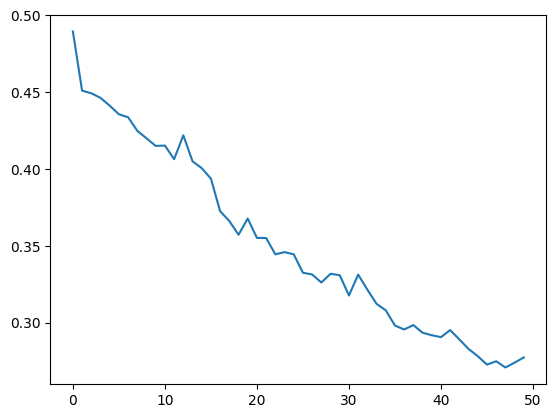

In [42]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [43]:
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [44]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))


1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 386ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step


In [45]:
generated_notes.head(10)

pitch      step  duration     start       end
0     47  0.097688  0.179285  0.097688  0.276973
1     72  0.858761  0.163204  0.956448  1.119652
2     84  1.089159  0.000000  2.045608  2.045608
3     84  1.095052  0.000000  3.140660  3.140660
4     89  1.108157  0.000000  4.248817  4.248817
5     89  1.118506  0.000000  5.367323  5.367323
6     84  1.135083  0.000000  6.502405  6.502405
7     90  1.128108  0.000000  7.630513  7.630513
8     84  1.129703  0.000000  8.760216  8.760216
9     84  1.155163  0.019010  9.915379  9.934389

In [46]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```


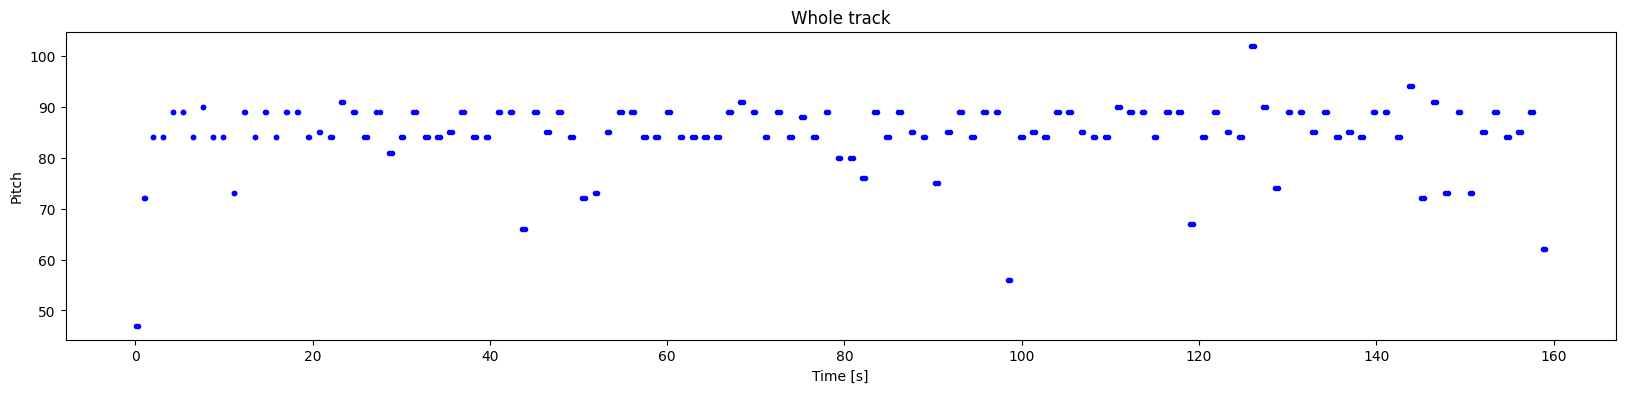

In [47]:
plot_piano_roll(generated_notes)

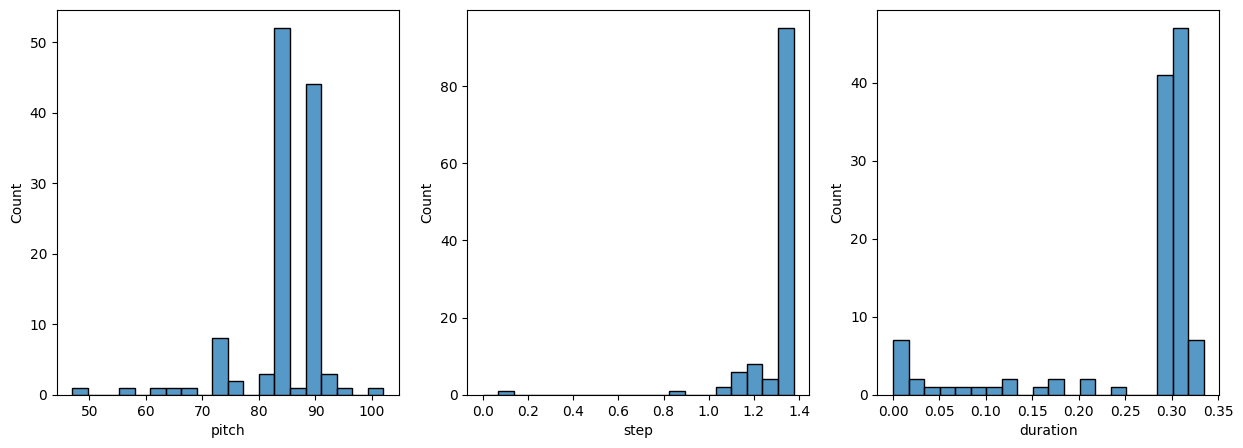

In [48]:
plot_distributions(generated_notes)